Dataset: randomly sample 500 discharge summaries (DS) from MIMIC-III. <br>
Description of the dataset: https://mimic.mit.edu/docs/iii/tables/ <br>

## Importing additional Python libraries<a class="anchor" id="1"></a>
<!-- <mark>[Return Contents](#0) -->

In [2]:
import pandas as pd
import nltk.data
import numpy as np
import matplotlib.pyplot as plt # plot figures
from nltk.corpus import PlaintextCorpusReader
import os, time, random, re, codecs, spacy, math, torch, spacy, transformers, nltk
from os.path import join
import seaborn as sns # plot figures
from os import listdir
from os.path import isfile, join
from sklearn.model_selection import train_test_split
from ipywidgets import IntProgress
from sklearn.metrics import classification_report
from transformers import AutoModel, BertTokenizerFast
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from sklearn.decomposition import PCA
import tensorflow as tf
import sklearn.metrics as metrics
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer 
from sklearn import metrics
import transformers
import torch
from torch.utils.data import Dataset, DataLoader, RandomSampler, SequentialSampler
from transformers import BertTokenizer, BertModel, BertConfig
from sklearn.preprocessing import LabelBinarizer, LabelEncoder
from sklearn.metrics import confusion_matrix
import tensorflow as tf
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.metrics import plot_roc_curve
from bert_sklearn import BertClassifier
from bert_sklearn import BertRegressor
from bert_sklearn import load_model
from sklearn.model_selection import GridSearchCV
from transformers import AdamW
import torch.optim as optim
import codecs, json, copy
from tqdm import tqdm
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from transformers.models.bert.modeling_bert import BertModel,BertForMaskedLM, BertForSequenceClassification
from sklearn.metrics import precision_recall_fscore_support
import warnings
warnings.filterwarnings('ignore') 

In [3]:
# Seeding:
def seed_all(seed):  
    ''' A function to seed everything for getting stable results and reproducibility'''
    random.seed(seed)
    np.random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
seed = 2021    
seed_all(seed)
# Testing size:
sizeoftest = 0.2

## Importing Dataset and preprocessing <a class="anchor" id="2"></a>
<!-- <mark>[Return Contents](#0) -->

In [4]:
path = ('....xlsx')
xl = pd.ExcelFile(path)
df = xl.parse('Sheet1')
# df.head()

In [6]:
df.shape

(1073, 14)

In [7]:
print(df.columns.tolist()) # column names

['ROW_ID', 'SUBJECT_ID', 'HADM_ID', 'CATEGORY', 'DESCRIPTION', 'TEXT_whole_doc', 'document structure', 'TEXT_in_doc_structure', 'mention', 'UMLS with desc', 'ORDO with desc', 'gold mention-to-UMLS label', 'gold UMLS-to-ORDO label', 'gold mention-to-ORDO label']


In [8]:
df.dtypes

ROW_ID                         int64
SUBJECT_ID                     int64
HADM_ID                        int64
CATEGORY                      object
DESCRIPTION                   object
TEXT_whole_doc                object
document structure            object
TEXT_in_doc_structure         object
mention                       object
UMLS with desc                object
ORDO with desc                object
gold mention-to-UMLS label     int64
gold UMLS-to-ORDO label        int64
gold mention-to-ORDO label     int64
dtype: object

In [9]:
df['document structure'].value_counts()

Hospital_course                         359
History_of_Past_Illness                 171
History_of_Present_Illness              139
pertinent_results                        64
Discharge_Diagnosis                      58
Discharge_Medications                    54
Admission_Medications                    49
basic                                    36
Hospital_Discharge_Physical              30
Review_of_Systems                        18
Chief_Complaint_and_Reason_for_Visit     15
facility                                 14
Social_History                           11
Procedures                                9
Hospital_Discharge_Studies                9
Hospital_Discharge_Instructions           8
interpretation                            7
admission_studies                         5
impression                                5
Problem                                   4
Immunizations                             2
Nutrition                                 2
Vital_Signs                     

### Data cleaning <a class="anchor" id="2_1"></a>

In [10]:
df.isnull().any()

ROW_ID                        False
SUBJECT_ID                    False
HADM_ID                       False
CATEGORY                      False
DESCRIPTION                   False
TEXT_whole_doc                False
document structure            False
TEXT_in_doc_structure         False
mention                       False
UMLS with desc                False
ORDO with desc                False
gold mention-to-UMLS label    False
gold UMLS-to-ORDO label       False
gold mention-to-ORDO label    False
dtype: bool

Class lable : `gold mention-to-UMLS label`: Check whether the matching is correct from the mention to the UMLS concept, 1 if correct, 0 if not.

In [11]:
df['gold mention-to-UMLS label'].value_counts() # 1 incorrect data for 'gold mention-to-UMLS label'

 0    743
 1    329
-1      1
Name: gold mention-to-UMLS label, dtype: int64

In [12]:
df.drop(df[df['gold mention-to-UMLS label'] == -1].index, inplace=True) # delete unexpected data

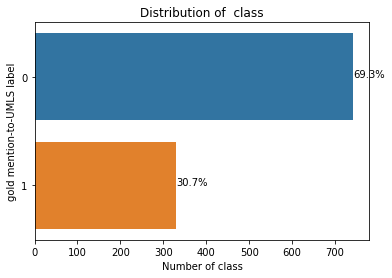

In [13]:
ax = sns.countplot(y="gold mention-to-UMLS label", data=df)
plt.title('Distribution of  class')
plt.xlabel('Number of class')
total = len(df['gold mention-to-UMLS label'])
for p in ax.patches:
        percentage = '{:.1f}%'.format(100 * p.get_width()/total)
        x = p.get_x() + p.get_width() + 0.02
        y = p.get_y() + p.get_height()/2
        ax.annotate(percentage, (x, y))
# plt.savefig('class_label')
plt.show()

## Generation of training and testing set<a class="anchor" id="6"></a>
<!-- <mark>[Return Contents](#0) -->

In [15]:
texts = df['mention'].tolist()
labels = df['gold mention-to-UMLS label'].tolist()
X, X_test, y, y_test = train_test_split(texts,
                                        labels,
                                        test_size=0.2,
                                        train_size=0.8,
                                        random_state=seed)
X_train, X_dev, y_train, y_dev = train_test_split(X,
                                                  y,
                                                  test_size=0.25,
                                                  train_size=0.75,
                                                  random_state=seed)
# len(X_train), len(y_train), len(X_test), len(y_test), len(X_dev), len(y_dev)
print("Train size:", len(X_train))
print("Dev size:", len(X_dev))
print("Test size:", len(X_test))

Train size: 642
Dev size: 215
Test size: 215


## Classification algorithm 1: BERT<a class="anchor" id="7"></a>
<!-- <mark>[Return Contents](#0) -->

### Loading pre-trained models<a class="anchor" id="7_1"></a>
Model from huggingface: https://huggingface.co/models

In [16]:
# import BERT-base pretrained model
bert = AutoModel.from_pretrained('bert-base-uncased')
# Load the BERT tokenizer
tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased')

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


### Loading data for training and testing<a class="anchor" id="7_1"></a>

In [17]:
def prepare_X_y(texts, labels):    
    tokenized = tokenizer.batch_encode_plus(
        texts,
        padding=True,
        truncation=True
    )
    seq = torch.tensor(tokenized['input_ids'])
    mask = torch.tensor(tokenized['attention_mask'])
    y = torch.tensor(labels)
    return seq, mask, y

train_seq, train_mask, train_y = prepare_X_y(X_train, y_train)
dev_seq, dev_mask, dev_y = prepare_X_y(X_dev, y_dev)
test_seq, test_mask, test_y = prepare_X_y(X_test, y_test)

### Define hyperparameters<a class="anchor" id="7_3"></a>

In [18]:
#define a batch size
batch_size = 5
epochs = 20
learning_rate = 1e-1

### Create a dataloader instance<a class="anchor" id="7_4"></a>

In [19]:
# wrap tensors
training_data = TensorDataset(train_seq, train_mask, train_y)
dev_data = TensorDataset(dev_seq, dev_mask, dev_y)
# testing_data = TensorDataset(test_seq, test_mask, test_y)

# sampler for sampling the data during training
sampler = RandomSampler(training_data)

# dataLoader
training_data_loader = DataLoader(training_data, sampler=sampler, batch_size=batch_size)
dev_data_loader = DataLoader(dev_data, batch_size=batch_size) 
# testing_data_loader = DataLoader(testing_data, sampler=sampler, batch_size=batch_size)

### Define BERT model<a class="anchor" id="7_5"></a>
- BERT pretrained model
- one feedforward layer

In [20]:
# Define the model

class BERT_Text_Classifier(nn.Module):
    
    def __init__(self, bert, class_num, bert_dim=768, hidden_dim=512):
      
        super(BERT_Text_Classifier, self).__init__()

        self.bert = bert 

        # define a dropout
        self.dropout = nn.Dropout(0.1)

        # use relu
        self.relu =  nn.ReLU()

        # feedforward layer
        self.fc1 = nn.Linear(bert_dim, hidden_dim)

        # Output layer
        self.fc2 = nn.Linear(hidden_dim, class_num)

        #softmax function instance
        self.softmax = nn.LogSoftmax(dim=1)

    #define the forward pass
    def forward(self, seq, mask):

        # use pretrained bert to read the sequence with the mask (pay attention to which tokens)
        bert_out = self.bert(seq, attention_mask=mask)
        
        # print('last_hidden_state', bert_out['last_hidden_state'].size(), 
        #      'pooler_output', bert_out['pooler_output'].size())
        
        lhs = bert_out['pooler_output']
        x = self.fc1(lhs)        
        x = self.relu(x)
        x = self.dropout(x)
        x = self.fc2(x)
        
        # apply softmax activation
        x = self.softmax(x)

        return x

### Evaluation function<a class="anchor" id="7_6"></a>

In [21]:
def evaluate(m, evl_loader, eval_labels=[1]):
    from sklearn.metrics import precision_recall_fscore_support
    preds = []
    lbls = []
    print('evaluating...', flush=True)
    for step, batch in enumerate(tqdm(evl_loader)):        
        # use gpu if available
        batch = [r.to(device) for r in batch]
        seq, mask, labels = batch
        with torch.no_grad():
            batch_result = m(seq, mask)
            rets = np.argmax(batch_result.detach().cpu(), axis = 1).tolist()
            preds += rets
            lbls += labels.tolist()
    p, r, f, _ = precision_recall_fscore_support(lbls, preds, labels=eval_labels)
    return {'precision': p[0], 'recall': r[0], 'f1': f[0]}

### Training function<a class="anchor" id="7_6"></a>

In [22]:
# function to train the model
def train():
    # dropout activates when in train mode 
    model.train()

    total_loss = 0
    for step, batch in enumerate(tqdm(training_data_loader)):
        
        # use gpu if available
        batch = [r.to(device) for r in batch]
        
        seq, mask, labels = batch
        
        # reset gradients 
        model.zero_grad()        

        # get model outputs
        outputs = model.forward(seq, mask)

        # compute the loss between actual and predicted values
        loss = cross_entropy(outputs, labels)

        # accumulate loss
        total_loss = total_loss + loss.item()

        # calculate the gradients
        loss.backward()

        # deal with the exploding gradient problem
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        # update parameters
        optimizer.step()

    # calculate average loss
    average_loss = total_loss / len(training_data_loader)
    
    ret = evaluate(model, dev_data_loader)
  
    return average_loss, ret

### Identify CPU/GPU device for training<a class="anchor" id="7_8"></a>

In [5]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# device

In [26]:
categories = {'control': 0, 'case': 1}
# initialise the model use pretrained bert instance and the label numbers
model = BERT_Text_Classifier(bert, class_num=len(categories))

# push the model to GPU
model = model.to(device)

# define the optimizer
# optimizer = AdamW(model.parameters(),
#                   lr = learning_rate)
optimizer = optim.SGD(model.parameters(), lr=learning_rate)

cross_entropy  = nn.NLLLoss() 

### Train the model<a class="anchor" id="7_9"></a>

In [27]:
#for each epoch

best_model_state = None
best_score = -1

for epoch in range(epochs):
     
    print('\n Epoch {:} / {:}'.format(epoch + 1, epochs), flush=True)
    #train model
    train_loss, performance = train()
    print('\nTraining Loss: {:.3f}'.format(train_loss), 
          'dev performance, p:{precision:.3f}, r:{recall:.3f}, f1:{f1:.3f}'.format(**performance), flush=True)
    if best_score < performance['f1']:
        best_score = performance['f1']
        best_model_state = copy.deepcopy(model.state_dict())
        print('current best score is {0:.3f}'.format(best_score), flush=True)    

ran = True


 Epoch 1 / 20


100%|██████████████████████████████████████████████████████████| 129/129 [00:03<00:00, 40.38it/s]

evaluating...



100%|███████████████████████████████████████████████████████████| 43/43 [00:00<00:00, 161.18it/s]


Training Loss: 0.383 dev performance, p:0.871, r:0.818, f1:0.844
current best score is 0.844

 Epoch 2 / 20



100%|██████████████████████████████████████████████████████████| 129/129 [00:03<00:00, 41.00it/s]

evaluating...



100%|███████████████████████████████████████████████████████████| 43/43 [00:00<00:00, 159.09it/s]


Training Loss: 0.282 dev performance, p:0.841, r:0.879, f1:0.859
current best score is 0.859

 Epoch 3 / 20



100%|██████████████████████████████████████████████████████████| 129/129 [00:03<00:00, 41.26it/s]

evaluating...



100%|███████████████████████████████████████████████████████████| 43/43 [00:00<00:00, 160.56it/s]


Training Loss: 0.201 dev performance, p:0.845, r:0.909, f1:0.876
current best score is 0.876

 Epoch 4 / 20



100%|██████████████████████████████████████████████████████████| 129/129 [00:03<00:00, 41.09it/s]

evaluating...



100%|███████████████████████████████████████████████████████████| 43/43 [00:00<00:00, 160.68it/s]


Training Loss: 0.184 dev performance, p:0.821, r:0.970, f1:0.889
current best score is 0.889

 Epoch 5 / 20



100%|██████████████████████████████████████████████████████████| 129/129 [00:03<00:00, 41.30it/s]

evaluating...



100%|███████████████████████████████████████████████████████████| 43/43 [00:00<00:00, 160.19it/s]


Training Loss: 0.151 dev performance, p:0.851, r:0.955, f1:0.900
current best score is 0.900

 Epoch 6 / 20



100%|██████████████████████████████████████████████████████████| 129/129 [00:03<00:00, 41.21it/s]

evaluating...



100%|███████████████████████████████████████████████████████████| 43/43 [00:00<00:00, 159.44it/s]


Training Loss: 0.138 dev performance, p:0.821, r:0.970, f1:0.889

 Epoch 7 / 20



100%|██████████████████████████████████████████████████████████| 129/129 [00:03<00:00, 41.20it/s]

evaluating...



100%|███████████████████████████████████████████████████████████| 43/43 [00:00<00:00, 161.39it/s]


Training Loss: 0.159 dev performance, p:0.863, r:0.955, f1:0.906
current best score is 0.906

 Epoch 8 / 20



100%|██████████████████████████████████████████████████████████| 129/129 [00:03<00:00, 41.31it/s]

evaluating...



100%|███████████████████████████████████████████████████████████| 43/43 [00:00<00:00, 160.03it/s]


Training Loss: 0.128 dev performance, p:0.851, r:0.955, f1:0.900

 Epoch 9 / 20



100%|██████████████████████████████████████████████████████████| 129/129 [00:03<00:00, 41.03it/s]

evaluating...



100%|███████████████████████████████████████████████████████████| 43/43 [00:00<00:00, 161.30it/s]


Training Loss: 0.156 dev performance, p:0.851, r:0.955, f1:0.900

 Epoch 10 / 20



100%|██████████████████████████████████████████████████████████| 129/129 [00:03<00:00, 41.40it/s]

evaluating...



100%|███████████████████████████████████████████████████████████| 43/43 [00:00<00:00, 157.72it/s]


Training Loss: 0.116 dev performance, p:0.859, r:0.924, f1:0.891

 Epoch 11 / 20



100%|██████████████████████████████████████████████████████████| 129/129 [00:03<00:00, 41.28it/s]

evaluating...



100%|███████████████████████████████████████████████████████████| 43/43 [00:00<00:00, 160.75it/s]


Training Loss: 0.129 dev performance, p:0.861, r:0.939, f1:0.899

 Epoch 12 / 20



100%|██████████████████████████████████████████████████████████| 129/129 [00:03<00:00, 41.28it/s]

evaluating...



100%|███████████████████████████████████████████████████████████| 43/43 [00:00<00:00, 160.27it/s]


Training Loss: 0.141 dev performance, p:0.855, r:0.894, f1:0.874

 Epoch 13 / 20



100%|██████████████████████████████████████████████████████████| 129/129 [00:03<00:00, 41.41it/s]

evaluating...



100%|███████████████████████████████████████████████████████████| 43/43 [00:00<00:00, 160.54it/s]


Training Loss: 0.106 dev performance, p:0.827, r:0.939, f1:0.879

 Epoch 14 / 20



100%|██████████████████████████████████████████████████████████| 129/129 [00:03<00:00, 41.42it/s]

evaluating...



100%|███████████████████████████████████████████████████████████| 43/43 [00:00<00:00, 161.30it/s]


Training Loss: 0.107 dev performance, p:0.842, r:0.970, f1:0.901

 Epoch 15 / 20



100%|██████████████████████████████████████████████████████████| 129/129 [00:03<00:00, 41.25it/s]

evaluating...



100%|███████████████████████████████████████████████████████████| 43/43 [00:00<00:00, 158.65it/s]


Training Loss: 0.107 dev performance, p:0.851, r:0.955, f1:0.900

 Epoch 16 / 20



100%|██████████████████████████████████████████████████████████| 129/129 [00:03<00:00, 41.39it/s]

evaluating...



100%|███████████████████████████████████████████████████████████| 43/43 [00:00<00:00, 161.58it/s]


Training Loss: 0.102 dev performance, p:0.863, r:0.955, f1:0.906

 Epoch 17 / 20



100%|██████████████████████████████████████████████████████████| 129/129 [00:03<00:00, 41.26it/s]

evaluating...



100%|███████████████████████████████████████████████████████████| 43/43 [00:00<00:00, 160.78it/s]


Training Loss: 0.104 dev performance, p:0.851, r:0.955, f1:0.900

 Epoch 18 / 20



100%|██████████████████████████████████████████████████████████| 129/129 [00:03<00:00, 41.49it/s]

evaluating...



100%|███████████████████████████████████████████████████████████| 43/43 [00:00<00:00, 160.20it/s]


Training Loss: 0.110 dev performance, p:0.829, r:0.955, f1:0.887

 Epoch 19 / 20



100%|██████████████████████████████████████████████████████████| 129/129 [00:03<00:00, 41.33it/s]

evaluating...



100%|███████████████████████████████████████████████████████████| 43/43 [00:00<00:00, 161.00it/s]


Training Loss: 0.107 dev performance, p:0.853, r:0.970, f1:0.908
current best score is 0.908

 Epoch 20 / 20



100%|██████████████████████████████████████████████████████████| 129/129 [00:03<00:00, 41.27it/s]

evaluating...



100%|███████████████████████████████████████████████████████████| 43/43 [00:00<00:00, 160.16it/s]


Training Loss: 0.112 dev performance, p:0.882, r:0.909, f1:0.896


### Save the model<a class="anchor" id="7_10"></a>

In [28]:
model_file = 'bert_initial_mimic.pt'
torch.save(best_model_state, model_file)

In [29]:
if not ran:
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    model_file = 'bert_initial_mimic.pt'

    categories = {'control': 0, 'case': 1}
    # initialise the model use pretrained bert instance and the label numbers
    model = BERT_Text_Classifier(bert, class_num=len(categories))

    model.load_state_dict(torch.load(model_file))
    model.eval()

### Test the model<a class="anchor" id="7_11"></a>

In [30]:
test_seq = test_seq.to(device)
test_mask = test_mask.to(device)
model = model.to(device)

In [31]:
# dataLoader for test set
# wrap tensors
testing_data = TensorDataset(test_seq, test_mask, test_y)
testing_data_loader = DataLoader(testing_data, batch_size=batch_size)     
print(evaluate(model, testing_data_loader))
# preds = np.argmax(preds.detach().cpu(), axis = 1)

evaluating...


100%|███████████████████████████████████████████████████████████| 43/43 [00:00<00:00, 161.47it/s]

{'precision': 0.9558823529411765, 'recall': 0.9558823529411765, 'f1': 0.9558823529411765}


In [32]:
# predicting, so gradients
with torch.no_grad():
    preds = model(test_seq, test_mask)
    
preds = np.argmax(preds.detach().cpu(), axis = 1)
print(classification_report(test_y, preds))
# report_BERT1 = classification_report(test_y, preds)
# classification_report_csv(report_BERT1)

              precision    recall  f1-score   support

           0       0.97      0.99      0.98       147
           1       0.97      0.93      0.95        68

    accuracy                           0.97       215
   macro avg       0.97      0.96      0.96       215
weighted avg       0.97      0.97      0.97       215



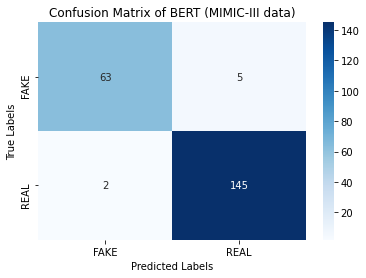

In [33]:
cm_bert_initial = confusion_matrix(test_y, preds, labels=[1,0])
ax= plt.subplot()
sns.heatmap(cm_bert_initial, annot=True, ax = ax, cmap='Blues', fmt="d")

ax.set_title('Confusion Matrix of BERT (MIMIC-III data)')

ax.set_xlabel('Predicted Labels')
ax.set_ylabel('True Labels')

ax.xaxis.set_ticklabels(['FAKE', 'REAL'])
ax.yaxis.set_ticklabels(['FAKE', 'REAL'])
plt.savefig('Confusion_matrix_bert_initial_mimic')

### Fine-tune hyperparameters<a class="anchor" id="7_12"></a>

In [34]:
os.environ["TOKENIZERS_PARALLELISM"] = "false"

In [35]:
# %%time
# from bert import run_classifier
params = {'epochs':[50, 75, 100], 'learning_rate':[2e-5, 3e-5, 1e-5]}

# wrap classifier/regressor in GridSearchCV
clf_bert = GridSearchCV(BertClassifier(validation_fraction=0, max_seq_length=64), 
                   params,
                   cv=3,
                   scoring='accuracy',
                   verbose=True)

# fit gridsearch 
clf_bert.fit(X_train ,y_train)

Building sklearn text classifier...
Building sklearn text classifier...
Fitting 3 folds for each of 9 candidates, totalling 27 fits
Building sklearn text classifier...
Loading bert-base-uncased model...
Defaulting to linear classifier/regressor
Loading Pytorch checkpoint
train data size: 428, validation data size: 0


Predicting: 100%|████████████████████████████████████████████████| 27/27 [00:00<00:00, 61.86it/s]


Building sklearn text classifier...
Loading bert-base-uncased model...
Defaulting to linear classifier/regressor
Loading Pytorch checkpoint
train data size: 428, validation data size: 0


Predicting: 100%|████████████████████████████████████████████████| 27/27 [00:00<00:00, 59.21it/s]


Building sklearn text classifier...
Loading bert-base-uncased model...
Defaulting to linear classifier/regressor
Loading Pytorch checkpoint
train data size: 428, validation data size: 0


Predicting: 100%|████████████████████████████████████████████████| 27/27 [00:00<00:00, 56.97it/s]


Building sklearn text classifier...
Loading bert-base-uncased model...
Defaulting to linear classifier/regressor
Loading Pytorch checkpoint
train data size: 428, validation data size: 0


Predicting: 100%|████████████████████████████████████████████████| 27/27 [00:00<00:00, 55.60it/s]


Building sklearn text classifier...
Loading bert-base-uncased model...
Defaulting to linear classifier/regressor
Loading Pytorch checkpoint
train data size: 428, validation data size: 0


Predicting: 100%|████████████████████████████████████████████████| 27/27 [00:00<00:00, 54.06it/s]


Building sklearn text classifier...
Loading bert-base-uncased model...
Defaulting to linear classifier/regressor
Loading Pytorch checkpoint
train data size: 428, validation data size: 0


Predicting: 100%|████████████████████████████████████████████████| 27/27 [00:00<00:00, 55.71it/s]


Building sklearn text classifier...
Loading bert-base-uncased model...
Defaulting to linear classifier/regressor
Loading Pytorch checkpoint
train data size: 428, validation data size: 0


Predicting: 100%|████████████████████████████████████████████████| 27/27 [00:00<00:00, 56.46it/s]


Building sklearn text classifier...
Loading bert-base-uncased model...
Defaulting to linear classifier/regressor
Loading Pytorch checkpoint
train data size: 428, validation data size: 0


Predicting: 100%|████████████████████████████████████████████████| 27/27 [00:00<00:00, 55.22it/s]


Building sklearn text classifier...
Loading bert-base-uncased model...
Defaulting to linear classifier/regressor
Loading Pytorch checkpoint
train data size: 428, validation data size: 0


Predicting: 100%|████████████████████████████████████████████████| 27/27 [00:00<00:00, 53.83it/s]


Building sklearn text classifier...
Loading bert-base-uncased model...
Defaulting to linear classifier/regressor
Loading Pytorch checkpoint
train data size: 428, validation data size: 0


Predicting: 100%|████████████████████████████████████████████████| 27/27 [00:00<00:00, 54.93it/s]


Building sklearn text classifier...
Loading bert-base-uncased model...
Defaulting to linear classifier/regressor
Loading Pytorch checkpoint
train data size: 428, validation data size: 0


Predicting: 100%|████████████████████████████████████████████████| 27/27 [00:00<00:00, 53.76it/s]


Building sklearn text classifier...
Loading bert-base-uncased model...
Defaulting to linear classifier/regressor
Loading Pytorch checkpoint
train data size: 428, validation data size: 0


Predicting: 100%|████████████████████████████████████████████████| 27/27 [00:00<00:00, 55.42it/s]


Building sklearn text classifier...
Loading bert-base-uncased model...
Defaulting to linear classifier/regressor
Loading Pytorch checkpoint
train data size: 428, validation data size: 0


Predicting: 100%|████████████████████████████████████████████████| 27/27 [00:00<00:00, 54.68it/s]


Building sklearn text classifier...
Loading bert-base-uncased model...
Defaulting to linear classifier/regressor
Loading Pytorch checkpoint
train data size: 428, validation data size: 0


Predicting: 100%|████████████████████████████████████████████████| 27/27 [00:00<00:00, 51.91it/s]


Building sklearn text classifier...
Loading bert-base-uncased model...
Defaulting to linear classifier/regressor
Loading Pytorch checkpoint
train data size: 428, validation data size: 0


Predicting: 100%|████████████████████████████████████████████████| 27/27 [00:00<00:00, 49.10it/s]


Building sklearn text classifier...
Loading bert-base-uncased model...
Defaulting to linear classifier/regressor
Loading Pytorch checkpoint
train data size: 428, validation data size: 0


Predicting: 100%|████████████████████████████████████████████████| 27/27 [00:00<00:00, 52.05it/s]


Building sklearn text classifier...
Loading bert-base-uncased model...
Defaulting to linear classifier/regressor
Loading Pytorch checkpoint
train data size: 428, validation data size: 0


Predicting: 100%|████████████████████████████████████████████████| 27/27 [00:00<00:00, 52.13it/s]


Building sklearn text classifier...
Loading bert-base-uncased model...
Defaulting to linear classifier/regressor
Loading Pytorch checkpoint
train data size: 428, validation data size: 0


Predicting: 100%|████████████████████████████████████████████████| 27/27 [00:00<00:00, 54.14it/s]


Building sklearn text classifier...
Loading bert-base-uncased model...
Defaulting to linear classifier/regressor
Loading Pytorch checkpoint
train data size: 428, validation data size: 0


Predicting: 100%|████████████████████████████████████████████████| 27/27 [00:00<00:00, 50.00it/s]


Building sklearn text classifier...
Loading bert-base-uncased model...
Defaulting to linear classifier/regressor
Loading Pytorch checkpoint
train data size: 428, validation data size: 0


Predicting: 100%|████████████████████████████████████████████████| 27/27 [00:00<00:00, 56.60it/s]


Building sklearn text classifier...
Loading bert-base-uncased model...
Defaulting to linear classifier/regressor
Loading Pytorch checkpoint
train data size: 428, validation data size: 0


Predicting: 100%|████████████████████████████████████████████████| 27/27 [00:00<00:00, 54.49it/s]


Building sklearn text classifier...
Loading bert-base-uncased model...
Defaulting to linear classifier/regressor
Loading Pytorch checkpoint
train data size: 428, validation data size: 0


Predicting: 100%|████████████████████████████████████████████████| 27/27 [00:00<00:00, 57.02it/s]


Building sklearn text classifier...
Loading bert-base-uncased model...
Defaulting to linear classifier/regressor
Loading Pytorch checkpoint
train data size: 428, validation data size: 0


Predicting: 100%|████████████████████████████████████████████████| 27/27 [00:00<00:00, 53.22it/s]


Building sklearn text classifier...
Loading bert-base-uncased model...
Defaulting to linear classifier/regressor
Loading Pytorch checkpoint
train data size: 428, validation data size: 0


Predicting: 100%|████████████████████████████████████████████████| 27/27 [00:00<00:00, 53.25it/s]


Building sklearn text classifier...
Loading bert-base-uncased model...
Defaulting to linear classifier/regressor
Loading Pytorch checkpoint
train data size: 428, validation data size: 0


Predicting: 100%|████████████████████████████████████████████████| 27/27 [00:00<00:00, 55.17it/s]


Building sklearn text classifier...
Loading bert-base-uncased model...
Defaulting to linear classifier/regressor
Loading Pytorch checkpoint
train data size: 428, validation data size: 0


Predicting: 100%|████████████████████████████████████████████████| 27/27 [00:00<00:00, 53.10it/s]


Building sklearn text classifier...
Loading bert-base-uncased model...
Defaulting to linear classifier/regressor
Loading Pytorch checkpoint
train data size: 428, validation data size: 0


Predicting: 100%|████████████████████████████████████████████████| 27/27 [00:00<00:00, 51.04it/s]


Building sklearn text classifier...
Building sklearn text classifier...
Loading bert-base-uncased model...
Defaulting to linear classifier/regressor
Loading Pytorch checkpoint
train data size: 642, validation data size: 0


Training  : 100%|███████████████████████████████████| 21/21 [00:03<00:00,  6.92it/s, loss=0.0534]


GridSearchCV(cv=3,
             estimator=BertClassifier(max_seq_length=64, validation_fraction=0),
             param_grid={'epochs': [50, 75, 100],
                         'learning_rate': [2e-05, 3e-05, 1e-05]},
             scoring='accuracy', verbose=True)

In [36]:
means = clf_bert.cv_results_['mean_test_score']
stds = clf_bert.cv_results_['std_test_score']

for mean, std, params in zip(means, stds, clf_bert.cv_results_['params']):
        print("%0.3f (+/-%0.03f) for %r"
              % (mean, std * 2, params))
        
# best scores
print("\nBest score:", clf_bert.best_score_,"with params:", clf_bert.best_params_)

0.950 (+/-0.004) for {'epochs': 50, 'learning_rate': 2e-05}
0.955 (+/-0.012) for {'epochs': 50, 'learning_rate': 3e-05}
0.952 (+/-0.009) for {'epochs': 50, 'learning_rate': 1e-05}
0.952 (+/-0.009) for {'epochs': 75, 'learning_rate': 2e-05}
0.952 (+/-0.009) for {'epochs': 75, 'learning_rate': 3e-05}
0.955 (+/-0.009) for {'epochs': 75, 'learning_rate': 1e-05}
0.955 (+/-0.009) for {'epochs': 100, 'learning_rate': 2e-05}
0.949 (+/-0.000) for {'epochs': 100, 'learning_rate': 3e-05}
0.955 (+/-0.009) for {'epochs': 100, 'learning_rate': 1e-05}

Best score: 0.9548286604361372 with params: {'epochs': 75, 'learning_rate': 1e-05}


In [37]:
# CUDA device (GPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
n_gpu = torch.cuda.device_count()
torch.cuda.get_device_name(0)
# Print state of GPU
# !nvidia-smi

'NVIDIA GeForce RTX 3090'

In [38]:
#define a batch size
batch_size = 5
epochs = 75
learning_rate = 1e-5

In [39]:
categories = {'control': 0, 'case': 1}
# initialise the model use pretrained bert_2 instance and the label numbers
model = BERT_Text_Classifier(bert, class_num=len(categories))

# push the model to GPU
model = model.to(device)

# define the optimizer
# optimizer = AdamW(model.parameters(),
#                   lr = learning_rate)
optimizer = optim.SGD(model.parameters(), lr=learning_rate)

cross_entropy  = nn.NLLLoss() 

In [40]:
#for each epoch

best_model_state = None
best_score = -1

for epoch in range(epochs):
     
    print('\n Epoch {:} / {:}'.format(epoch + 1, epochs), flush=True)
    #train model
    train_loss, performance = train()
    print('\nTraining Loss: {:.3f}'.format(train_loss), 
          'dev performance, p:{precision:.3f}, r:{recall:.3f}, f1:{f1:.3f}'.format(**performance), flush=True)
    if best_score < performance['f1']:
        best_score = performance['f1']
        best_model_state = copy.deepcopy(model.state_dict())
        print('current best score is {0:.3f}'.format(best_score), flush=True)    

ran = True


 Epoch 1 / 75


100%|██████████████████████████████████████████████████████████| 129/129 [00:03<00:00, 38.45it/s]

evaluating...



100%|███████████████████████████████████████████████████████████| 43/43 [00:00<00:00, 158.18it/s]


Training Loss: 0.933 dev performance, p:0.041, r:0.091, f1:0.057
current best score is 0.057

 Epoch 2 / 75



100%|██████████████████████████████████████████████████████████| 129/129 [00:03<00:00, 38.77it/s]

evaluating...



100%|███████████████████████████████████████████████████████████| 43/43 [00:00<00:00, 157.69it/s]


Training Loss: 0.923 dev performance, p:0.022, r:0.045, f1:0.029

 Epoch 3 / 75



100%|██████████████████████████████████████████████████████████| 129/129 [00:03<00:00, 38.69it/s]

evaluating...



100%|███████████████████████████████████████████████████████████| 43/43 [00:00<00:00, 159.62it/s]


Training Loss: 0.913 dev performance, p:0.049, r:0.106, f1:0.067
current best score is 0.067

 Epoch 4 / 75



100%|██████████████████████████████████████████████████████████| 129/129 [00:03<00:00, 38.75it/s]

evaluating...



100%|███████████████████████████████████████████████████████████| 43/43 [00:00<00:00, 158.46it/s]


Training Loss: 0.901 dev performance, p:0.035, r:0.076, f1:0.048

 Epoch 5 / 75



100%|██████████████████████████████████████████████████████████| 129/129 [00:03<00:00, 38.74it/s]

evaluating...



100%|███████████████████████████████████████████████████████████| 43/43 [00:00<00:00, 159.98it/s]


Training Loss: 0.896 dev performance, p:0.022, r:0.045, f1:0.029

 Epoch 6 / 75



100%|██████████████████████████████████████████████████████████| 129/129 [00:03<00:00, 38.73it/s]

evaluating...



100%|███████████████████████████████████████████████████████████| 43/43 [00:00<00:00, 158.28it/s]


Training Loss: 0.879 dev performance, p:0.035, r:0.076, f1:0.048

 Epoch 7 / 75



100%|██████████████████████████████████████████████████████████| 129/129 [00:03<00:00, 38.83it/s]

evaluating...



100%|███████████████████████████████████████████████████████████| 43/43 [00:00<00:00, 158.90it/s]


Training Loss: 0.879 dev performance, p:0.021, r:0.045, f1:0.029

 Epoch 8 / 75



100%|██████████████████████████████████████████████████████████| 129/129 [00:03<00:00, 38.79it/s]

evaluating...



100%|███████████████████████████████████████████████████████████| 43/43 [00:00<00:00, 161.09it/s]


Training Loss: 0.872 dev performance, p:0.048, r:0.106, f1:0.066

 Epoch 9 / 75



100%|██████████████████████████████████████████████████████████| 129/129 [00:03<00:00, 38.79it/s]

evaluating...



100%|███████████████████████████████████████████████████████████| 43/43 [00:00<00:00, 159.79it/s]


Training Loss: 0.864 dev performance, p:0.049, r:0.106, f1:0.067

 Epoch 10 / 75



100%|██████████████████████████████████████████████████████████| 129/129 [00:03<00:00, 38.88it/s]

evaluating...



100%|███████████████████████████████████████████████████████████| 43/43 [00:00<00:00, 159.43it/s]


Training Loss: 0.855 dev performance, p:0.029, r:0.061, f1:0.039

 Epoch 11 / 75



100%|██████████████████████████████████████████████████████████| 129/129 [00:03<00:00, 38.81it/s]

evaluating...



100%|███████████████████████████████████████████████████████████| 43/43 [00:00<00:00, 159.77it/s]


Training Loss: 0.844 dev performance, p:0.036, r:0.076, f1:0.049

 Epoch 12 / 75



100%|██████████████████████████████████████████████████████████| 129/129 [00:03<00:00, 38.85it/s]

evaluating...



100%|███████████████████████████████████████████████████████████| 43/43 [00:00<00:00, 159.08it/s]


Training Loss: 0.840 dev performance, p:0.030, r:0.061, f1:0.040

 Epoch 13 / 75



100%|██████████████████████████████████████████████████████████| 129/129 [00:03<00:00, 38.81it/s]

evaluating...



100%|███████████████████████████████████████████████████████████| 43/43 [00:00<00:00, 161.05it/s]


Training Loss: 0.829 dev performance, p:0.030, r:0.061, f1:0.040

 Epoch 14 / 75



100%|██████████████████████████████████████████████████████████| 129/129 [00:03<00:00, 38.82it/s]

evaluating...



100%|███████████████████████████████████████████████████████████| 43/43 [00:00<00:00, 158.73it/s]


Training Loss: 0.820 dev performance, p:0.016, r:0.030, f1:0.021

 Epoch 15 / 75



100%|██████████████████████████████████████████████████████████| 129/129 [00:03<00:00, 38.90it/s]

evaluating...



100%|███████████████████████████████████████████████████████████| 43/43 [00:00<00:00, 159.92it/s]


Training Loss: 0.809 dev performance, p:0.016, r:0.030, f1:0.021

 Epoch 16 / 75



100%|██████████████████████████████████████████████████████████| 129/129 [00:03<00:00, 38.81it/s]

evaluating...



100%|███████████████████████████████████████████████████████████| 43/43 [00:00<00:00, 159.16it/s]


Training Loss: 0.804 dev performance, p:0.026, r:0.045, f1:0.033

 Epoch 17 / 75



100%|██████████████████████████████████████████████████████████| 129/129 [00:03<00:00, 38.89it/s]

evaluating...



100%|███████████████████████████████████████████████████████████| 43/43 [00:00<00:00, 159.06it/s]


Training Loss: 0.799 dev performance, p:0.035, r:0.061, f1:0.045

 Epoch 18 / 75



100%|██████████████████████████████████████████████████████████| 129/129 [00:03<00:00, 38.84it/s]

evaluating...



100%|███████████████████████████████████████████████████████████| 43/43 [00:00<00:00, 161.03it/s]


Training Loss: 0.788 dev performance, p:0.040, r:0.061, f1:0.048

 Epoch 19 / 75



100%|██████████████████████████████████████████████████████████| 129/129 [00:03<00:00, 38.86it/s]

evaluating...



100%|███████████████████████████████████████████████████████████| 43/43 [00:00<00:00, 158.82it/s]


Training Loss: 0.776 dev performance, p:0.011, r:0.015, f1:0.012

 Epoch 20 / 75



100%|██████████████████████████████████████████████████████████| 129/129 [00:03<00:00, 38.88it/s]

evaluating...



100%|███████████████████████████████████████████████████████████| 43/43 [00:00<00:00, 161.08it/s]


Training Loss: 0.768 dev performance, p:0.045, r:0.061, f1:0.052

 Epoch 21 / 75



100%|██████████████████████████████████████████████████████████| 129/129 [00:03<00:00, 38.84it/s]

evaluating...



100%|███████████████████████████████████████████████████████████| 43/43 [00:00<00:00, 160.48it/s]


Training Loss: 0.762 dev performance, p:0.013, r:0.015, f1:0.014

 Epoch 22 / 75



100%|██████████████████████████████████████████████████████████| 129/129 [00:03<00:00, 38.86it/s]

evaluating...



100%|███████████████████████████████████████████████████████████| 43/43 [00:00<00:00, 158.80it/s]


Training Loss: 0.757 dev performance, p:0.081, r:0.076, f1:0.078
current best score is 0.078

 Epoch 23 / 75



100%|██████████████████████████████████████████████████████████| 129/129 [00:03<00:00, 38.95it/s]

evaluating...



100%|███████████████████████████████████████████████████████████| 43/43 [00:00<00:00, 160.66it/s]


Training Loss: 0.748 dev performance, p:0.068, r:0.061, f1:0.064

 Epoch 24 / 75



100%|██████████████████████████████████████████████████████████| 129/129 [00:03<00:00, 38.99it/s]

evaluating...



100%|███████████████████████████████████████████████████████████| 43/43 [00:00<00:00, 159.95it/s]


Training Loss: 0.741 dev performance, p:0.038, r:0.030, f1:0.034

 Epoch 25 / 75



100%|██████████████████████████████████████████████████████████| 129/129 [00:03<00:00, 38.93it/s]

evaluating...



100%|███████████████████████████████████████████████████████████| 43/43 [00:00<00:00, 161.60it/s]


Training Loss: 0.735 dev performance, p:0.070, r:0.045, f1:0.055

 Epoch 26 / 75



100%|██████████████████████████████████████████████████████████| 129/129 [00:03<00:00, 38.93it/s]

evaluating...



100%|███████████████████████████████████████████████████████████| 43/43 [00:00<00:00, 159.18it/s]


Training Loss: 0.728 dev performance, p:0.067, r:0.030, f1:0.042

 Epoch 27 / 75



100%|██████████████████████████████████████████████████████████| 129/129 [00:03<00:00, 38.95it/s]

evaluating...



100%|███████████████████████████████████████████████████████████| 43/43 [00:00<00:00, 161.67it/s]


Training Loss: 0.718 dev performance, p:0.105, r:0.030, f1:0.047

 Epoch 28 / 75



100%|██████████████████████████████████████████████████████████| 129/129 [00:03<00:00, 38.91it/s]

evaluating...



100%|███████████████████████████████████████████████████████████| 43/43 [00:00<00:00, 159.22it/s]


Training Loss: 0.709 dev performance, p:0.050, r:0.015, f1:0.023

 Epoch 29 / 75



100%|██████████████████████████████████████████████████████████| 129/129 [00:03<00:00, 38.96it/s]

evaluating...



100%|███████████████████████████████████████████████████████████| 43/43 [00:00<00:00, 159.60it/s]


Training Loss: 0.705 dev performance, p:0.143, r:0.045, f1:0.069

 Epoch 30 / 75



100%|██████████████████████████████████████████████████████████| 129/129 [00:03<00:00, 38.93it/s]

evaluating...



100%|███████████████████████████████████████████████████████████| 43/43 [00:00<00:00, 160.44it/s]


Training Loss: 0.699 dev performance, p:0.133, r:0.030, f1:0.049

 Epoch 31 / 75



100%|██████████████████████████████████████████████████████████| 129/129 [00:03<00:00, 38.95it/s]

evaluating...



100%|███████████████████████████████████████████████████████████| 43/43 [00:00<00:00, 159.64it/s]


Training Loss: 0.691 dev performance, p:0.125, r:0.015, f1:0.027

 Epoch 32 / 75



100%|██████████████████████████████████████████████████████████| 129/129 [00:03<00:00, 38.94it/s]

evaluating...



100%|███████████████████████████████████████████████████████████| 43/43 [00:00<00:00, 160.76it/s]


Training Loss: 0.686 dev performance, p:0.000, r:0.000, f1:0.000

 Epoch 33 / 75



100%|██████████████████████████████████████████████████████████| 129/129 [00:03<00:00, 38.92it/s]

evaluating...



100%|███████████████████████████████████████████████████████████| 43/43 [00:00<00:00, 159.03it/s]


Training Loss: 0.675 dev performance, p:0.000, r:0.000, f1:0.000

 Epoch 34 / 75



100%|██████████████████████████████████████████████████████████| 129/129 [00:03<00:00, 38.90it/s]

evaluating...



100%|███████████████████████████████████████████████████████████| 43/43 [00:00<00:00, 160.51it/s]


Training Loss: 0.667 dev performance, p:0.000, r:0.000, f1:0.000

 Epoch 35 / 75



100%|██████████████████████████████████████████████████████████| 129/129 [00:03<00:00, 38.91it/s]

evaluating...



100%|███████████████████████████████████████████████████████████| 43/43 [00:00<00:00, 159.13it/s]


Training Loss: 0.667 dev performance, p:0.500, r:0.030, f1:0.057

 Epoch 36 / 75



100%|██████████████████████████████████████████████████████████| 129/129 [00:03<00:00, 38.93it/s]

evaluating...



100%|███████████████████████████████████████████████████████████| 43/43 [00:00<00:00, 160.55it/s]


Training Loss: 0.660 dev performance, p:0.000, r:0.000, f1:0.000

 Epoch 37 / 75



100%|██████████████████████████████████████████████████████████| 129/129 [00:03<00:00, 38.87it/s]

evaluating...



100%|███████████████████████████████████████████████████████████| 43/43 [00:00<00:00, 160.91it/s]


Training Loss: 0.651 dev performance, p:0.500, r:0.015, f1:0.029

 Epoch 38 / 75



100%|██████████████████████████████████████████████████████████| 129/129 [00:03<00:00, 38.94it/s]

evaluating...



100%|███████████████████████████████████████████████████████████| 43/43 [00:00<00:00, 159.91it/s]


Training Loss: 0.646 dev performance, p:0.000, r:0.000, f1:0.000

 Epoch 39 / 75



100%|██████████████████████████████████████████████████████████| 129/129 [00:03<00:00, 38.90it/s]

evaluating...



100%|███████████████████████████████████████████████████████████| 43/43 [00:00<00:00, 160.36it/s]


Training Loss: 0.636 dev performance, p:0.000, r:0.000, f1:0.000

 Epoch 40 / 75



100%|██████████████████████████████████████████████████████████| 129/129 [00:03<00:00, 38.93it/s]

evaluating...



100%|███████████████████████████████████████████████████████████| 43/43 [00:00<00:00, 158.94it/s]


Training Loss: 0.632 dev performance, p:1.000, r:0.015, f1:0.030

 Epoch 41 / 75



100%|██████████████████████████████████████████████████████████| 129/129 [00:03<00:00, 38.88it/s]

evaluating...



100%|███████████████████████████████████████████████████████████| 43/43 [00:00<00:00, 161.54it/s]


Training Loss: 0.623 dev performance, p:0.000, r:0.000, f1:0.000

 Epoch 42 / 75



100%|██████████████████████████████████████████████████████████| 129/129 [00:03<00:00, 38.93it/s]

evaluating...



100%|███████████████████████████████████████████████████████████| 43/43 [00:00<00:00, 159.81it/s]


Training Loss: 0.621 dev performance, p:1.000, r:0.030, f1:0.059

 Epoch 43 / 75



100%|██████████████████████████████████████████████████████████| 129/129 [00:03<00:00, 38.96it/s]

evaluating...



100%|███████████████████████████████████████████████████████████| 43/43 [00:00<00:00, 160.83it/s]


Training Loss: 0.610 dev performance, p:1.000, r:0.030, f1:0.059

 Epoch 44 / 75



100%|██████████████████████████████████████████████████████████| 129/129 [00:03<00:00, 38.92it/s]

evaluating...



100%|███████████████████████████████████████████████████████████| 43/43 [00:00<00:00, 160.58it/s]


Training Loss: 0.607 dev performance, p:0.750, r:0.045, f1:0.086
current best score is 0.086

 Epoch 45 / 75



100%|██████████████████████████████████████████████████████████| 129/129 [00:03<00:00, 38.94it/s]

evaluating...



100%|███████████████████████████████████████████████████████████| 43/43 [00:00<00:00, 159.38it/s]


Training Loss: 0.602 dev performance, p:1.000, r:0.076, f1:0.141
current best score is 0.141

 Epoch 46 / 75



100%|██████████████████████████████████████████████████████████| 129/129 [00:03<00:00, 38.92it/s]

evaluating...



100%|███████████████████████████████████████████████████████████| 43/43 [00:00<00:00, 160.39it/s]


Training Loss: 0.596 dev performance, p:1.000, r:0.015, f1:0.030

 Epoch 47 / 75



100%|██████████████████████████████████████████████████████████| 129/129 [00:03<00:00, 38.93it/s]

evaluating...



100%|███████████████████████████████████████████████████████████| 43/43 [00:00<00:00, 159.34it/s]


Training Loss: 0.588 dev performance, p:0.600, r:0.045, f1:0.085

 Epoch 48 / 75



100%|██████████████████████████████████████████████████████████| 129/129 [00:03<00:00, 38.98it/s]

evaluating...



100%|███████████████████████████████████████████████████████████| 43/43 [00:00<00:00, 161.72it/s]


Training Loss: 0.580 dev performance, p:1.000, r:0.076, f1:0.141

 Epoch 49 / 75



100%|██████████████████████████████████████████████████████████| 129/129 [00:03<00:00, 39.00it/s]

evaluating...



100%|███████████████████████████████████████████████████████████| 43/43 [00:00<00:00, 159.25it/s]


Training Loss: 0.576 dev performance, p:1.000, r:0.045, f1:0.087

 Epoch 50 / 75



100%|██████████████████████████████████████████████████████████| 129/129 [00:03<00:00, 38.98it/s]

evaluating...



100%|███████████████████████████████████████████████████████████| 43/43 [00:00<00:00, 161.67it/s]


Training Loss: 0.571 dev performance, p:0.800, r:0.061, f1:0.113

 Epoch 51 / 75



100%|██████████████████████████████████████████████████████████| 129/129 [00:03<00:00, 38.98it/s]

evaluating...



100%|███████████████████████████████████████████████████████████| 43/43 [00:00<00:00, 159.65it/s]


Training Loss: 0.566 dev performance, p:0.750, r:0.091, f1:0.162
current best score is 0.162

 Epoch 52 / 75



100%|██████████████████████████████████████████████████████████| 129/129 [00:03<00:00, 39.06it/s]

evaluating...



100%|███████████████████████████████████████████████████████████| 43/43 [00:00<00:00, 160.19it/s]


Training Loss: 0.560 dev performance, p:0.857, r:0.091, f1:0.164
current best score is 0.164

 Epoch 53 / 75



100%|██████████████████████████████████████████████████████████| 129/129 [00:03<00:00, 38.98it/s]

evaluating...



100%|███████████████████████████████████████████████████████████| 43/43 [00:00<00:00, 160.08it/s]


Training Loss: 0.553 dev performance, p:0.900, r:0.136, f1:0.237
current best score is 0.237

 Epoch 54 / 75



100%|██████████████████████████████████████████████████████████| 129/129 [00:03<00:00, 38.95it/s]

evaluating...



100%|███████████████████████████████████████████████████████████| 43/43 [00:00<00:00, 158.81it/s]


Training Loss: 0.548 dev performance, p:0.889, r:0.121, f1:0.213

 Epoch 55 / 75



100%|██████████████████████████████████████████████████████████| 129/129 [00:03<00:00, 39.00it/s]

evaluating...



100%|███████████████████████████████████████████████████████████| 43/43 [00:00<00:00, 160.23it/s]


Training Loss: 0.545 dev performance, p:0.917, r:0.167, f1:0.282
current best score is 0.282

 Epoch 56 / 75



100%|██████████████████████████████████████████████████████████| 129/129 [00:03<00:00, 39.01it/s]

evaluating...



100%|███████████████████████████████████████████████████████████| 43/43 [00:00<00:00, 159.12it/s]


Training Loss: 0.539 dev performance, p:0.750, r:0.227, f1:0.349
current best score is 0.349

 Epoch 57 / 75



100%|██████████████████████████████████████████████████████████| 129/129 [00:03<00:00, 38.98it/s]

evaluating...



100%|███████████████████████████████████████████████████████████| 43/43 [00:00<00:00, 161.19it/s]


Training Loss: 0.532 dev performance, p:0.909, r:0.152, f1:0.260

 Epoch 58 / 75



100%|██████████████████████████████████████████████████████████| 129/129 [00:03<00:00, 38.95it/s]

evaluating...



100%|███████████████████████████████████████████████████████████| 43/43 [00:00<00:00, 159.56it/s]


Training Loss: 0.526 dev performance, p:0.826, r:0.288, f1:0.427
current best score is 0.427

 Epoch 59 / 75



100%|██████████████████████████████████████████████████████████| 129/129 [00:03<00:00, 39.02it/s]

evaluating...



100%|███████████████████████████████████████████████████████████| 43/43 [00:00<00:00, 160.79it/s]


Training Loss: 0.518 dev performance, p:0.875, r:0.212, f1:0.341

 Epoch 60 / 75



100%|██████████████████████████████████████████████████████████| 129/129 [00:03<00:00, 39.02it/s]

evaluating...



100%|███████████████████████████████████████████████████████████| 43/43 [00:00<00:00, 159.69it/s]


Training Loss: 0.518 dev performance, p:0.895, r:0.258, f1:0.400

 Epoch 61 / 75



100%|██████████████████████████████████████████████████████████| 129/129 [00:03<00:00, 39.06it/s]

evaluating...



100%|███████████████████████████████████████████████████████████| 43/43 [00:00<00:00, 159.90it/s]


Training Loss: 0.508 dev performance, p:0.857, r:0.364, f1:0.511
current best score is 0.511

 Epoch 62 / 75



100%|██████████████████████████████████████████████████████████| 129/129 [00:03<00:00, 38.97it/s]

evaluating...



100%|███████████████████████████████████████████████████████████| 43/43 [00:00<00:00, 160.95it/s]


Training Loss: 0.506 dev performance, p:0.865, r:0.485, f1:0.621
current best score is 0.621

 Epoch 63 / 75



100%|██████████████████████████████████████████████████████████| 129/129 [00:03<00:00, 39.02it/s]

evaluating...



100%|███████████████████████████████████████████████████████████| 43/43 [00:00<00:00, 159.44it/s]


Training Loss: 0.499 dev performance, p:0.880, r:0.333, f1:0.484

 Epoch 64 / 75



100%|██████████████████████████████████████████████████████████| 129/129 [00:03<00:00, 38.98it/s]

evaluating...



100%|███████████████████████████████████████████████████████████| 43/43 [00:00<00:00, 160.94it/s]


Training Loss: 0.490 dev performance, p:0.929, r:0.394, f1:0.553

 Epoch 65 / 75



100%|██████████████████████████████████████████████████████████| 129/129 [00:03<00:00, 39.04it/s]

evaluating...



100%|███████████████████████████████████████████████████████████| 43/43 [00:00<00:00, 160.54it/s]


Training Loss: 0.491 dev performance, p:1.000, r:0.515, f1:0.680
current best score is 0.680

 Epoch 66 / 75



100%|██████████████████████████████████████████████████████████| 129/129 [00:03<00:00, 38.95it/s]

evaluating...



100%|███████████████████████████████████████████████████████████| 43/43 [00:00<00:00, 160.32it/s]


Training Loss: 0.492 dev performance, p:0.833, r:0.379, f1:0.521

 Epoch 67 / 75



100%|██████████████████████████████████████████████████████████| 129/129 [00:03<00:00, 38.94it/s]

evaluating...



100%|███████████████████████████████████████████████████████████| 43/43 [00:00<00:00, 159.66it/s]


Training Loss: 0.479 dev performance, p:0.894, r:0.636, f1:0.743
current best score is 0.743

 Epoch 68 / 75



100%|██████████████████████████████████████████████████████████| 129/129 [00:03<00:00, 39.00it/s]

evaluating...



100%|███████████████████████████████████████████████████████████| 43/43 [00:00<00:00, 160.22it/s]


Training Loss: 0.480 dev performance, p:0.881, r:0.561, f1:0.685

 Epoch 69 / 75



100%|██████████████████████████████████████████████████████████| 129/129 [00:03<00:00, 39.03it/s]

evaluating...



100%|███████████████████████████████████████████████████████████| 43/43 [00:00<00:00, 160.68it/s]


Training Loss: 0.470 dev performance, p:0.864, r:0.576, f1:0.691

 Epoch 70 / 75



100%|██████████████████████████████████████████████████████████| 129/129 [00:03<00:00, 38.97it/s]

evaluating...



100%|███████████████████████████████████████████████████████████| 43/43 [00:00<00:00, 159.56it/s]


Training Loss: 0.467 dev performance, p:0.872, r:0.621, f1:0.726

 Epoch 71 / 75



100%|██████████████████████████████████████████████████████████| 129/129 [00:03<00:00, 38.93it/s]

evaluating...



100%|███████████████████████████████████████████████████████████| 43/43 [00:00<00:00, 161.56it/s]


Training Loss: 0.462 dev performance, p:0.952, r:0.606, f1:0.741

 Epoch 72 / 75



100%|██████████████████████████████████████████████████████████| 129/129 [00:03<00:00, 38.93it/s]

evaluating...



100%|███████████████████████████████████████████████████████████| 43/43 [00:00<00:00, 160.07it/s]


Training Loss: 0.462 dev performance, p:0.911, r:0.621, f1:0.739

 Epoch 73 / 75



100%|██████████████████████████████████████████████████████████| 129/129 [00:03<00:00, 38.96it/s]

evaluating...



100%|███████████████████████████████████████████████████████████| 43/43 [00:00<00:00, 160.91it/s]


Training Loss: 0.454 dev performance, p:0.925, r:0.742, f1:0.824
current best score is 0.824

 Epoch 74 / 75



100%|██████████████████████████████████████████████████████████| 129/129 [00:03<00:00, 38.86it/s]

evaluating...



100%|███████████████████████████████████████████████████████████| 43/43 [00:00<00:00, 159.35it/s]


Training Loss: 0.448 dev performance, p:0.878, r:0.652, f1:0.748

 Epoch 75 / 75



100%|██████████████████████████████████████████████████████████| 129/129 [00:03<00:00, 38.84it/s]

evaluating...



100%|███████████████████████████████████████████████████████████| 43/43 [00:00<00:00, 159.61it/s]


Training Loss: 0.447 dev performance, p:0.887, r:0.712, f1:0.790


In [41]:
model_file = 'bert_finetune_mimic.pt'
torch.save(best_model_state, model_file)

In [42]:
if not ran:
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    model_file = 'bert_finetune_mimic.pt'

    categories = {'control': 0, 'case': 1}
    # initialise the model use pretrained bert instance and the label numbers
    model = BERT_Text_Classifier(bert_2, class_num=len(categories))

    model.load_state_dict(torch.load(model_file))
    model.eval()

### Test the optimized BERT

In [43]:
test_seq = test_seq.to(device)
test_mask = test_mask.to(device)
model = model.to(device)

In [44]:
# dataLoader for test set
# wrap tensors
testing_data = TensorDataset(test_seq, test_mask, test_y)
testing_data_loader = DataLoader(testing_data, batch_size=batch_size)     
print(evaluate(model, testing_data_loader))
# preds = np.argmax(preds.detach().cpu(), axis = 1)

evaluating...


100%|███████████████████████████████████████████████████████████| 43/43 [00:00<00:00, 160.03it/s]

{'precision': 0.9444444444444444, 'recall': 0.75, 'f1': 0.8360655737704917}


In [45]:
# predicting, so gradients
with torch.no_grad():
    preds = model(test_seq, test_mask)
    
preds = np.argmax(preds.detach().cpu(), axis = 1)
print(classification_report(test_y, preds))

              precision    recall  f1-score   support

           0       0.85      0.99      0.92       147
           1       0.98      0.63      0.77        68

    accuracy                           0.88       215
   macro avg       0.92      0.81      0.84       215
weighted avg       0.89      0.88      0.87       215



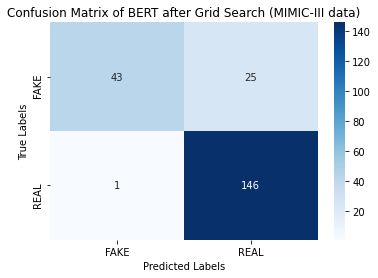

In [46]:
cm_bert_finetune = confusion_matrix(test_y, preds, labels=[1,0])
ax= plt.subplot()
sns.heatmap(cm_bert_finetune, annot=True, ax = ax, cmap='Blues', fmt="d")

ax.set_title('Confusion Matrix of BERT after Grid Search (MIMIC-III data)')

ax.set_xlabel('Predicted Labels')
ax.set_ylabel('True Labels')

ax.xaxis.set_ticklabels(['FAKE', 'REAL'])
ax.yaxis.set_ticklabels(['FAKE', 'REAL'])
plt.savefig('Confusion_matrix_BERT(grid search)_mimic')

## Classification algorithm 2: BlueBERT
### Train the BlueBERT

In [47]:
# bionlp/bluebert_pubmed_mimic_uncased_L-12_H-768_A-12
# import BERT-base pretrained model
bert_2 = AutoModel.from_pretrained('bionlp/bluebert_pubmed_mimic_uncased_L-12_H-768_A-12')
# Load the BERT tokenizer
tokenizer_2 = BertTokenizerFast.from_pretrained('bionlp/bluebert_pubmed_mimic_uncased_L-12_H-768_A-12')

Some weights of the model checkpoint at bionlp/bluebert_pubmed_mimic_uncased_L-12_H-768_A-12 were not used when initializing BertModel: ['cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.decoder.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [48]:
def prepare_X_y(texts, labels):    
    tokenized = tokenizer_2.batch_encode_plus(
        texts,
        padding=True,
        truncation=True
    )
    seq = torch.tensor(tokenized['input_ids'])
    mask = torch.tensor(tokenized['attention_mask'])
    y = torch.tensor(labels)
    return seq, mask, y

train_seq, train_mask, train_y = prepare_X_y(X_train, y_train)
dev_seq, dev_mask, dev_y = prepare_X_y(X_dev, y_dev)
test_seq, test_mask, test_y = prepare_X_y(X_test, y_test)

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


In [49]:
#define a batch size
batch_size = 5
epochs = 20
learning_rate = 1e-1

In [50]:
# wrap tensors
training_data = TensorDataset(train_seq, train_mask, train_y)
dev_data = TensorDataset(dev_seq, dev_mask, dev_y)
# testing_data = TensorDataset(test_seq, test_mask, test_y)

# sampler for sampling the data during training
sampler = RandomSampler(training_data)

# dataLoader
training_data_loader = DataLoader(training_data, sampler=sampler, batch_size=batch_size)
dev_data_loader = DataLoader(dev_data, batch_size=batch_size) 
# testing_data_loader = DataLoader(testing_data, sampler=sampler, batch_size=batch_size)

In [51]:
# Define the model

class BERT_Text_Classifier(nn.Module):
    
    def __init__(self, bert_2, class_num, bert_dim=768, hidden_dim=512):
      
        super(BERT_Text_Classifier, self).__init__()

        self.bert_2 = bert_2 

        # define a dropout
        self.dropout = nn.Dropout(0.1)

        # use relu
        self.relu =  nn.ReLU()

        # feedforward layer
        self.fc1 = nn.Linear(bert_dim, hidden_dim)

        # Output layer
        self.fc2 = nn.Linear(hidden_dim, class_num)

        #softmax function instance
        self.softmax = nn.LogSoftmax(dim=1)

    #define the forward pass
    def forward(self, seq, mask):

        # use pretrained bert_2 to read the sequence with the mask (pay attention to which tokens)
        bert_out = self.bert_2(seq, attention_mask=mask)
        
        # print('last_hidden_state', bert_out['last_hidden_state'].size(), 
        #      'pooler_output', bert_out['pooler_output'].size())
        
        lhs = bert_out['pooler_output']
        x = self.fc1(lhs)        
        x = self.relu(x)
        x = self.dropout(x)
        x = self.fc2(x)
        
        # apply softmax activation
        x = self.softmax(x)

        return x

In [52]:
def evaluate(m, evl_loader, eval_labels=[1]):
    from sklearn.metrics import precision_recall_fscore_support
    preds = []
    lbls = []
    print('evaluating...', flush=True)
    for step, batch in enumerate(tqdm(evl_loader)):        
        # use gpu if available
        batch = [r.to(device) for r in batch]
        seq, mask, labels = batch
        with torch.no_grad():
            batch_result = m(seq, mask)
            rets = np.argmax(batch_result.detach().cpu(), axis = 1).tolist()
            preds += rets
            lbls += labels.tolist()
    p, r, f, _ = precision_recall_fscore_support(lbls, preds, labels=eval_labels)
    return {'precision': p[0], 'recall': r[0], 'f1': f[0]}

In [53]:
# function to train the model
def train():
    # dropout activates when in train mode 
    model.train()

    total_loss = 0
    for step, batch in enumerate(tqdm(training_data_loader)):
        
        # use gpu if available
        batch = [r.to(device) for r in batch]
        
        seq, mask, labels = batch
        
        # reset gradients 
        model.zero_grad()        

        # get model outputs
        outputs = model.forward(seq, mask)

        # compute the loss between actual and predicted values
        loss = cross_entropy(outputs, labels)

        # accumulate loss
        total_loss = total_loss + loss.item()

        # calculate the gradients
        loss.backward()

        # deal with the exploding gradient problem
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        # update parameters
        optimizer.step()

    # calculate average loss
    average_loss = total_loss / len(training_data_loader)
    
    ret = evaluate(model, dev_data_loader)
  
    return average_loss, ret

In [54]:
categories = {'control': 0, 'case': 1}
# initialise the model use pretrained bert_2 instance and the label numbers
model = BERT_Text_Classifier(bert_2, class_num=len(categories))

# push the model to GPU
model = model.to(device)

# define the optimizer
# optimizer = AdamW(model.parameters(),
#                   lr = learning_rate)
optimizer = optim.SGD(model.parameters(), lr=learning_rate)

cross_entropy  = nn.NLLLoss() 

In [55]:
#for each epoch

best_model_state = None
best_score = -1

for epoch in range(epochs):
     
    print('\n Epoch {:} / {:}'.format(epoch + 1, epochs), flush=True)
    #train model
    train_loss, performance = train()
    print('\nTraining Loss: {:.3f}'.format(train_loss), 
          'dev performance, p:{precision:.3f}, r:{recall:.3f}, f1:{f1:.3f}'.format(**performance), flush=True)
    if best_score < performance['f1']:
        best_score = performance['f1']
        best_model_state = copy.deepcopy(model.state_dict())
        print('current best score is {0:.3f}'.format(best_score), flush=True)    

ran = True


 Epoch 1 / 20


100%|██████████████████████████████████████████████████████████| 129/129 [00:03<00:00, 38.71it/s]

evaluating...



100%|███████████████████████████████████████████████████████████| 43/43 [00:00<00:00, 132.52it/s]


Training Loss: 0.326 dev performance, p:0.913, r:0.636, f1:0.750
current best score is 0.750

 Epoch 2 / 20



100%|██████████████████████████████████████████████████████████| 129/129 [00:03<00:00, 39.41it/s]

evaluating...



100%|███████████████████████████████████████████████████████████| 43/43 [00:00<00:00, 155.12it/s]


Training Loss: 0.262 dev performance, p:0.882, r:0.909, f1:0.896
current best score is 0.896

 Epoch 3 / 20



100%|██████████████████████████████████████████████████████████| 129/129 [00:03<00:00, 40.67it/s]

evaluating...



100%|███████████████████████████████████████████████████████████| 43/43 [00:00<00:00, 160.68it/s]


Training Loss: 0.197 dev performance, p:0.851, r:0.955, f1:0.900
current best score is 0.900

 Epoch 4 / 20



100%|██████████████████████████████████████████████████████████| 129/129 [00:03<00:00, 41.34it/s]

evaluating...



100%|███████████████████████████████████████████████████████████| 43/43 [00:00<00:00, 161.24it/s]


Training Loss: 0.137 dev performance, p:0.877, r:0.970, f1:0.921
current best score is 0.921

 Epoch 5 / 20



100%|██████████████████████████████████████████████████████████| 129/129 [00:03<00:00, 41.33it/s]

evaluating...



100%|███████████████████████████████████████████████████████████| 43/43 [00:00<00:00, 160.28it/s]


Training Loss: 0.162 dev performance, p:0.881, r:0.894, f1:0.887

 Epoch 6 / 20



100%|██████████████████████████████████████████████████████████| 129/129 [00:03<00:00, 40.33it/s]

evaluating...



100%|███████████████████████████████████████████████████████████| 43/43 [00:00<00:00, 152.75it/s]


Training Loss: 0.151 dev performance, p:0.887, r:0.955, f1:0.920

 Epoch 7 / 20



100%|██████████████████████████████████████████████████████████| 129/129 [00:03<00:00, 40.52it/s]

evaluating...



100%|███████████████████████████████████████████████████████████| 43/43 [00:00<00:00, 157.77it/s]


Training Loss: 0.132 dev performance, p:0.889, r:0.970, f1:0.928
current best score is 0.928

 Epoch 8 / 20



100%|██████████████████████████████████████████████████████████| 129/129 [00:03<00:00, 41.07it/s]

evaluating...



100%|███████████████████████████████████████████████████████████| 43/43 [00:00<00:00, 160.24it/s]


Training Loss: 0.126 dev performance, p:0.886, r:0.939, f1:0.912

 Epoch 9 / 20



100%|██████████████████████████████████████████████████████████| 129/129 [00:03<00:00, 41.19it/s]

evaluating...



100%|███████████████████████████████████████████████████████████| 43/43 [00:00<00:00, 157.18it/s]


Training Loss: 0.138 dev performance, p:0.887, r:0.955, f1:0.920

 Epoch 10 / 20



100%|██████████████████████████████████████████████████████████| 129/129 [00:03<00:00, 41.14it/s]

evaluating...



100%|███████████████████████████████████████████████████████████| 43/43 [00:00<00:00, 159.07it/s]


Training Loss: 0.103 dev performance, p:0.886, r:0.939, f1:0.912

 Epoch 11 / 20



100%|██████████████████████████████████████████████████████████| 129/129 [00:03<00:00, 41.23it/s]

evaluating...



100%|███████████████████████████████████████████████████████████| 43/43 [00:00<00:00, 159.13it/s]


Training Loss: 0.099 dev performance, p:0.900, r:0.955, f1:0.926

 Epoch 12 / 20



100%|██████████████████████████████████████████████████████████| 129/129 [00:03<00:00, 41.25it/s]

evaluating...



100%|███████████████████████████████████████████████████████████| 43/43 [00:00<00:00, 160.50it/s]


Training Loss: 0.104 dev performance, p:0.887, r:0.955, f1:0.920

 Epoch 13 / 20



100%|██████████████████████████████████████████████████████████| 129/129 [00:03<00:00, 36.69it/s]

evaluating...



100%|███████████████████████████████████████████████████████████| 43/43 [00:00<00:00, 147.42it/s]


Training Loss: 0.147 dev performance, p:0.853, r:0.970, f1:0.908

 Epoch 14 / 20



100%|██████████████████████████████████████████████████████████| 129/129 [00:03<00:00, 39.90it/s]

evaluating...



100%|███████████████████████████████████████████████████████████| 43/43 [00:00<00:00, 157.36it/s]


Training Loss: 0.128 dev performance, p:0.886, r:0.939, f1:0.912

 Epoch 15 / 20



100%|██████████████████████████████████████████████████████████| 129/129 [00:03<00:00, 41.02it/s]

evaluating...



100%|███████████████████████████████████████████████████████████| 43/43 [00:00<00:00, 159.88it/s]


Training Loss: 0.119 dev performance, p:0.823, r:0.985, f1:0.897

 Epoch 16 / 20



100%|██████████████████████████████████████████████████████████| 129/129 [00:03<00:00, 40.98it/s]

evaluating...



100%|███████████████████████████████████████████████████████████| 43/43 [00:00<00:00, 157.24it/s]


Training Loss: 0.130 dev performance, p:0.840, r:0.955, f1:0.894

 Epoch 17 / 20



100%|██████████████████████████████████████████████████████████| 129/129 [00:03<00:00, 41.06it/s]

evaluating...



100%|███████████████████████████████████████████████████████████| 43/43 [00:00<00:00, 159.82it/s]


Training Loss: 0.117 dev performance, p:0.900, r:0.955, f1:0.926

 Epoch 18 / 20



100%|██████████████████████████████████████████████████████████| 129/129 [00:03<00:00, 41.12it/s]

evaluating...



100%|███████████████████████████████████████████████████████████| 43/43 [00:00<00:00, 157.51it/s]


Training Loss: 0.109 dev performance, p:0.900, r:0.955, f1:0.926

 Epoch 19 / 20



100%|██████████████████████████████████████████████████████████| 129/129 [00:03<00:00, 41.06it/s]

evaluating...



100%|███████████████████████████████████████████████████████████| 43/43 [00:00<00:00, 159.85it/s]


Training Loss: 0.116 dev performance, p:0.889, r:0.970, f1:0.928

 Epoch 20 / 20



100%|██████████████████████████████████████████████████████████| 129/129 [00:03<00:00, 41.03it/s]

evaluating...



100%|███████████████████████████████████████████████████████████| 43/43 [00:00<00:00, 157.62it/s]


Training Loss: 0.098 dev performance, p:0.863, r:0.955, f1:0.906


In [56]:
model_file = 'bluebert_initial_mimic.pt'
torch.save(best_model_state, model_file)

In [57]:
if not ran:
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    model_file = 'bluebert_initial_mimic.pt'

    categories = {'control': 0, 'case': 1}
    # initialise the model use pretrained bert instance and the label numbers
    model = BERT_Text_Classifier(bert_2, class_num=len(categories))

    model.load_state_dict(torch.load(model_file))
    model.eval()

### Test the BlueBERT

In [58]:
test_seq = test_seq.to(device)
test_mask = test_mask.to(device)
model = model.to(device)

In [59]:
# dataLoader for test set
# wrap tensors
testing_data = TensorDataset(test_seq, test_mask, test_y)
testing_data_loader = DataLoader(testing_data, batch_size=batch_size)     
print(evaluate(model, testing_data_loader))
# preds = np.argmax(preds.detach().cpu(), axis = 1)

evaluating...


100%|███████████████████████████████████████████████████████████| 43/43 [00:00<00:00, 159.01it/s]

{'precision': 0.9558823529411765, 'recall': 0.9558823529411765, 'f1': 0.9558823529411765}


In [60]:
# predicting, so gradients
with torch.no_grad():
    preds = model(test_seq, test_mask)
    
preds = np.argmax(preds.detach().cpu(), axis = 1)
print(classification_report(test_y, preds))

              precision    recall  f1-score   support

           0       0.98      0.97      0.97       147
           1       0.93      0.96      0.94        68

    accuracy                           0.96       215
   macro avg       0.95      0.96      0.96       215
weighted avg       0.96      0.96      0.96       215



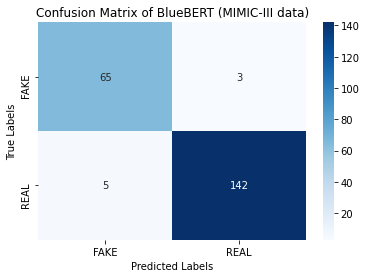

In [61]:
cm_bert = confusion_matrix(test_y, preds, labels=[1,0])
ax= plt.subplot()
sns.heatmap(cm_bert, annot=True, ax = ax, cmap='Blues', fmt="d")

ax.set_title('Confusion Matrix of BlueBERT (MIMIC-III data)')

ax.set_xlabel('Predicted Labels')
ax.set_ylabel('True Labels')

ax.xaxis.set_ticklabels(['FAKE', 'REAL'])
ax.yaxis.set_ticklabels(['FAKE', 'REAL'])
plt.savefig('Confusion_matrix_BlueBERT_mimic')

### Grid search of BlueBERT for optimization

In [62]:
# %%time
# from bert import run_classifier
params = {'epochs':[50, 75, 100], 'learning_rate':[2e-5, 3e-5, 1e-5]}

# wrap classifier/regressor in GridSearchCV
clf_bert = GridSearchCV(BertClassifier(validation_fraction=0, max_seq_length=64), 
                   params,
                   cv=3,
                   scoring='accuracy',
                   verbose=True)

# fit gridsearch 
clf_bert.fit(X_train ,y_train)

Building sklearn text classifier...
Building sklearn text classifier...
Fitting 3 folds for each of 9 candidates, totalling 27 fits
Building sklearn text classifier...
Loading bert-base-uncased model...
Defaulting to linear classifier/regressor
Loading Pytorch checkpoint
train data size: 428, validation data size: 0


Predicting: 100%|████████████████████████████████████████████████| 27/27 [00:00<00:00, 48.46it/s]


Building sklearn text classifier...
Loading bert-base-uncased model...
Defaulting to linear classifier/regressor
Loading Pytorch checkpoint
train data size: 428, validation data size: 0


Predicting: 100%|████████████████████████████████████████████████| 27/27 [00:00<00:00, 50.13it/s]


Building sklearn text classifier...
Loading bert-base-uncased model...
Defaulting to linear classifier/regressor
Loading Pytorch checkpoint
train data size: 428, validation data size: 0


Predicting: 100%|████████████████████████████████████████████████| 27/27 [00:00<00:00, 49.34it/s]


Building sklearn text classifier...
Loading bert-base-uncased model...
Defaulting to linear classifier/regressor
Loading Pytorch checkpoint
train data size: 428, validation data size: 0


Predicting: 100%|████████████████████████████████████████████████| 27/27 [00:00<00:00, 48.58it/s]


Building sklearn text classifier...
Loading bert-base-uncased model...
Defaulting to linear classifier/regressor
Loading Pytorch checkpoint
train data size: 428, validation data size: 0


Predicting: 100%|████████████████████████████████████████████████| 27/27 [00:00<00:00, 48.28it/s]


Building sklearn text classifier...
Loading bert-base-uncased model...
Defaulting to linear classifier/regressor
Loading Pytorch checkpoint
train data size: 428, validation data size: 0


Predicting: 100%|████████████████████████████████████████████████| 27/27 [00:00<00:00, 47.49it/s]


Building sklearn text classifier...
Loading bert-base-uncased model...
Defaulting to linear classifier/regressor
Loading Pytorch checkpoint
train data size: 428, validation data size: 0


Predicting: 100%|████████████████████████████████████████████████| 27/27 [00:00<00:00, 48.64it/s]


Building sklearn text classifier...
Loading bert-base-uncased model...
Defaulting to linear classifier/regressor
Loading Pytorch checkpoint
train data size: 428, validation data size: 0


Predicting: 100%|████████████████████████████████████████████████| 27/27 [00:00<00:00, 48.83it/s]


Building sklearn text classifier...
Loading bert-base-uncased model...
Defaulting to linear classifier/regressor
Loading Pytorch checkpoint
train data size: 428, validation data size: 0


Predicting: 100%|████████████████████████████████████████████████| 27/27 [00:00<00:00, 50.26it/s]


Building sklearn text classifier...
Loading bert-base-uncased model...
Defaulting to linear classifier/regressor
Loading Pytorch checkpoint
train data size: 428, validation data size: 0


Predicting: 100%|████████████████████████████████████████████████| 27/27 [00:00<00:00, 48.36it/s]


Building sklearn text classifier...
Loading bert-base-uncased model...
Defaulting to linear classifier/regressor
Loading Pytorch checkpoint
train data size: 428, validation data size: 0


Predicting: 100%|████████████████████████████████████████████████| 27/27 [00:00<00:00, 47.15it/s]


Building sklearn text classifier...
Loading bert-base-uncased model...
Defaulting to linear classifier/regressor
Loading Pytorch checkpoint
train data size: 428, validation data size: 0


Predicting: 100%|████████████████████████████████████████████████| 27/27 [00:00<00:00, 46.63it/s]


Building sklearn text classifier...
Loading bert-base-uncased model...
Defaulting to linear classifier/regressor
Loading Pytorch checkpoint
train data size: 428, validation data size: 0


Predicting: 100%|████████████████████████████████████████████████| 27/27 [00:00<00:00, 43.93it/s]


Building sklearn text classifier...
Loading bert-base-uncased model...
Defaulting to linear classifier/regressor
Loading Pytorch checkpoint
train data size: 428, validation data size: 0


Predicting: 100%|████████████████████████████████████████████████| 27/27 [00:00<00:00, 45.47it/s]


Building sklearn text classifier...
Loading bert-base-uncased model...
Defaulting to linear classifier/regressor
Loading Pytorch checkpoint
train data size: 428, validation data size: 0


Predicting: 100%|████████████████████████████████████████████████| 27/27 [00:00<00:00, 49.33it/s]


Building sklearn text classifier...
Loading bert-base-uncased model...
Defaulting to linear classifier/regressor
Loading Pytorch checkpoint
train data size: 428, validation data size: 0


Predicting: 100%|████████████████████████████████████████████████| 27/27 [00:00<00:00, 51.50it/s]


Building sklearn text classifier...
Loading bert-base-uncased model...
Defaulting to linear classifier/regressor
Loading Pytorch checkpoint
train data size: 428, validation data size: 0


Predicting: 100%|████████████████████████████████████████████████| 27/27 [00:00<00:00, 51.81it/s]


Building sklearn text classifier...
Loading bert-base-uncased model...
Defaulting to linear classifier/regressor
Loading Pytorch checkpoint
train data size: 428, validation data size: 0


Predicting: 100%|████████████████████████████████████████████████| 27/27 [00:00<00:00, 50.33it/s]


Building sklearn text classifier...
Loading bert-base-uncased model...
Defaulting to linear classifier/regressor
Loading Pytorch checkpoint
train data size: 428, validation data size: 0


Predicting: 100%|████████████████████████████████████████████████| 27/27 [00:00<00:00, 50.33it/s]


Building sklearn text classifier...
Loading bert-base-uncased model...
Defaulting to linear classifier/regressor
Loading Pytorch checkpoint
train data size: 428, validation data size: 0


Predicting: 100%|████████████████████████████████████████████████| 27/27 [00:00<00:00, 50.43it/s]


Building sklearn text classifier...
Loading bert-base-uncased model...
Defaulting to linear classifier/regressor
Loading Pytorch checkpoint
train data size: 428, validation data size: 0


Predicting: 100%|████████████████████████████████████████████████| 27/27 [00:00<00:00, 50.35it/s]


Building sklearn text classifier...
Loading bert-base-uncased model...
Defaulting to linear classifier/regressor
Loading Pytorch checkpoint
train data size: 428, validation data size: 0


Predicting: 100%|████████████████████████████████████████████████| 27/27 [00:00<00:00, 50.35it/s]


Building sklearn text classifier...
Loading bert-base-uncased model...
Defaulting to linear classifier/regressor
Loading Pytorch checkpoint
train data size: 428, validation data size: 0


Predicting: 100%|████████████████████████████████████████████████| 27/27 [00:00<00:00, 51.42it/s]


Building sklearn text classifier...
Loading bert-base-uncased model...
Defaulting to linear classifier/regressor
Loading Pytorch checkpoint
train data size: 428, validation data size: 0


Predicting: 100%|████████████████████████████████████████████████| 27/27 [00:00<00:00, 50.10it/s]


Building sklearn text classifier...
Loading bert-base-uncased model...
Defaulting to linear classifier/regressor
Loading Pytorch checkpoint
train data size: 428, validation data size: 0


Predicting: 100%|████████████████████████████████████████████████| 27/27 [00:00<00:00, 50.65it/s]


Building sklearn text classifier...
Loading bert-base-uncased model...
Defaulting to linear classifier/regressor
Loading Pytorch checkpoint
train data size: 428, validation data size: 0


Predicting: 100%|████████████████████████████████████████████████| 27/27 [00:00<00:00, 50.29it/s]


Building sklearn text classifier...
Loading bert-base-uncased model...
Defaulting to linear classifier/regressor
Loading Pytorch checkpoint
train data size: 428, validation data size: 0


Predicting: 100%|████████████████████████████████████████████████| 27/27 [00:00<00:00, 48.20it/s]


Building sklearn text classifier...
Building sklearn text classifier...
Loading bert-base-uncased model...
Defaulting to linear classifier/regressor
Loading Pytorch checkpoint
train data size: 642, validation data size: 0


Training  : 100%|███████████████████████████████████| 21/21 [00:03<00:00,  6.94it/s, loss=0.0534]


GridSearchCV(cv=3,
             estimator=BertClassifier(max_seq_length=64, validation_fraction=0),
             param_grid={'epochs': [50, 75, 100],
                         'learning_rate': [2e-05, 3e-05, 1e-05]},
             scoring='accuracy', verbose=True)

In [63]:
means = clf_bert.cv_results_['mean_test_score']
stds = clf_bert.cv_results_['std_test_score']

for mean, std, params in zip(means, stds, clf_bert.cv_results_['params']):
        print("%0.3f (+/-%0.03f) for %r"
              % (mean, std * 2, params))
        
# best scores
print("\nBest score:", clf_bert.best_score_,"with params:", clf_bert.best_params_)

0.950 (+/-0.004) for {'epochs': 50, 'learning_rate': 2e-05}
0.955 (+/-0.012) for {'epochs': 50, 'learning_rate': 3e-05}
0.952 (+/-0.009) for {'epochs': 50, 'learning_rate': 1e-05}
0.952 (+/-0.009) for {'epochs': 75, 'learning_rate': 2e-05}
0.952 (+/-0.009) for {'epochs': 75, 'learning_rate': 3e-05}
0.955 (+/-0.009) for {'epochs': 75, 'learning_rate': 1e-05}
0.955 (+/-0.009) for {'epochs': 100, 'learning_rate': 2e-05}
0.949 (+/-0.000) for {'epochs': 100, 'learning_rate': 3e-05}
0.955 (+/-0.009) for {'epochs': 100, 'learning_rate': 1e-05}

Best score: 0.9548286604361372 with params: {'epochs': 75, 'learning_rate': 1e-05}


In [64]:
#define a batch size
batch_size = 5
epochs = 75
learning_rate = 1e-5

In [65]:
categories = {'control': 0, 'case': 1}
# initialise the model use pretrained bert_2 instance and the label numbers
model = BERT_Text_Classifier(bert_2, class_num=len(categories))

# push the model to GPU
model = model.to(device)

# define the optimizer
# optimizer = AdamW(model.parameters(),
#                   lr = learning_rate)
optimizer = optim.SGD(model.parameters(), lr=learning_rate)

cross_entropy  = nn.NLLLoss() 

In [66]:
#for each epoch

best_model_state = None
best_score = -1

for epoch in range(epochs):
     
    print('\n Epoch {:} / {:}'.format(epoch + 1, epochs), flush=True)
    #train model
    train_loss, performance = train()
    print('\nTraining Loss: {:.3f}'.format(train_loss), 
          'dev performance, p:{precision:.3f}, r:{recall:.3f}, f1:{f1:.3f}'.format(**performance), flush=True)
    if best_score < performance['f1']:
        best_score = performance['f1']
        best_model_state = copy.deepcopy(model.state_dict())
        print('current best score is {0:.3f}'.format(best_score), flush=True)    

ran = True


 Epoch 1 / 75


100%|██████████████████████████████████████████████████████████| 129/129 [00:03<00:00, 38.41it/s]

evaluating...



100%|███████████████████████████████████████████████████████████| 43/43 [00:00<00:00, 159.43it/s]


Training Loss: 0.881 dev performance, p:0.021, r:0.045, f1:0.029
current best score is 0.029

 Epoch 2 / 75



100%|██████████████████████████████████████████████████████████| 129/129 [00:03<00:00, 38.49it/s]

evaluating...



100%|███████████████████████████████████████████████████████████| 43/43 [00:00<00:00, 159.29it/s]


Training Loss: 0.876 dev performance, p:0.014, r:0.030, f1:0.019

 Epoch 3 / 75



100%|██████████████████████████████████████████████████████████| 129/129 [00:03<00:00, 38.50it/s]

evaluating...



100%|███████████████████████████████████████████████████████████| 43/43 [00:00<00:00, 159.23it/s]


Training Loss: 0.874 dev performance, p:0.014, r:0.030, f1:0.020

 Epoch 4 / 75



100%|██████████████████████████████████████████████████████████| 129/129 [00:03<00:00, 38.47it/s]

evaluating...



100%|███████████████████████████████████████████████████████████| 43/43 [00:00<00:00, 159.44it/s]


Training Loss: 0.866 dev performance, p:0.021, r:0.045, f1:0.029
current best score is 0.029

 Epoch 5 / 75



100%|██████████████████████████████████████████████████████████| 129/129 [00:03<00:00, 38.57it/s]

evaluating...



100%|███████████████████████████████████████████████████████████| 43/43 [00:00<00:00, 157.89it/s]


Training Loss: 0.860 dev performance, p:0.015, r:0.030, f1:0.020

 Epoch 6 / 75



100%|██████████████████████████████████████████████████████████| 129/129 [00:03<00:00, 38.52it/s]

evaluating...



100%|███████████████████████████████████████████████████████████| 43/43 [00:00<00:00, 159.23it/s]


Training Loss: 0.854 dev performance, p:0.015, r:0.030, f1:0.020

 Epoch 7 / 75



100%|██████████████████████████████████████████████████████████| 129/129 [00:03<00:00, 38.58it/s]

evaluating...



100%|███████████████████████████████████████████████████████████| 43/43 [00:00<00:00, 158.75it/s]


Training Loss: 0.851 dev performance, p:0.015, r:0.030, f1:0.020

 Epoch 8 / 75



100%|██████████████████████████████████████████████████████████| 129/129 [00:03<00:00, 38.59it/s]

evaluating...



100%|███████████████████████████████████████████████████████████| 43/43 [00:00<00:00, 159.02it/s]


Training Loss: 0.845 dev performance, p:0.015, r:0.030, f1:0.020

 Epoch 9 / 75



100%|██████████████████████████████████████████████████████████| 129/129 [00:03<00:00, 38.57it/s]

evaluating...



100%|███████████████████████████████████████████████████████████| 43/43 [00:00<00:00, 160.59it/s]


Training Loss: 0.842 dev performance, p:0.015, r:0.030, f1:0.020

 Epoch 10 / 75



100%|██████████████████████████████████████████████████████████| 129/129 [00:03<00:00, 38.61it/s]

evaluating...



100%|███████████████████████████████████████████████████████████| 43/43 [00:00<00:00, 158.92it/s]


Training Loss: 0.836 dev performance, p:0.015, r:0.030, f1:0.020

 Epoch 11 / 75



100%|██████████████████████████████████████████████████████████| 129/129 [00:03<00:00, 38.67it/s]

evaluating...



100%|███████████████████████████████████████████████████████████| 43/43 [00:00<00:00, 158.45it/s]


Training Loss: 0.825 dev performance, p:0.008, r:0.015, f1:0.010

 Epoch 12 / 75



100%|██████████████████████████████████████████████████████████| 129/129 [00:03<00:00, 38.60it/s]

evaluating...



100%|███████████████████████████████████████████████████████████| 43/43 [00:00<00:00, 159.77it/s]


Training Loss: 0.830 dev performance, p:0.015, r:0.030, f1:0.020

 Epoch 13 / 75



100%|██████████████████████████████████████████████████████████| 129/129 [00:03<00:00, 38.63it/s]

evaluating...



100%|███████████████████████████████████████████████████████████| 43/43 [00:00<00:00, 158.45it/s]


Training Loss: 0.823 dev performance, p:0.015, r:0.030, f1:0.020

 Epoch 14 / 75



100%|██████████████████████████████████████████████████████████| 129/129 [00:03<00:00, 38.58it/s]

evaluating...



100%|███████████████████████████████████████████████████████████| 43/43 [00:00<00:00, 159.44it/s]


Training Loss: 0.815 dev performance, p:0.023, r:0.045, f1:0.030
current best score is 0.030

 Epoch 15 / 75



100%|██████████████████████████████████████████████████████████| 129/129 [00:03<00:00, 38.58it/s]

evaluating...



100%|███████████████████████████████████████████████████████████| 43/43 [00:00<00:00, 159.69it/s]


Training Loss: 0.808 dev performance, p:0.007, r:0.015, f1:0.010

 Epoch 16 / 75



100%|██████████████████████████████████████████████████████████| 129/129 [00:03<00:00, 38.62it/s]

evaluating...



100%|███████████████████████████████████████████████████████████| 43/43 [00:00<00:00, 159.38it/s]


Training Loss: 0.803 dev performance, p:0.008, r:0.015, f1:0.010

 Epoch 17 / 75



100%|██████████████████████████████████████████████████████████| 129/129 [00:03<00:00, 38.62it/s]

evaluating...



100%|███████████████████████████████████████████████████████████| 43/43 [00:00<00:00, 160.76it/s]


Training Loss: 0.801 dev performance, p:0.008, r:0.015, f1:0.010

 Epoch 18 / 75



100%|██████████████████████████████████████████████████████████| 129/129 [00:03<00:00, 38.60it/s]

evaluating...



100%|███████████████████████████████████████████████████████████| 43/43 [00:00<00:00, 159.47it/s]


Training Loss: 0.797 dev performance, p:0.008, r:0.015, f1:0.011

 Epoch 19 / 75



100%|██████████████████████████████████████████████████████████| 129/129 [00:03<00:00, 38.67it/s]

evaluating...



100%|███████████████████████████████████████████████████████████| 43/43 [00:00<00:00, 158.83it/s]


Training Loss: 0.790 dev performance, p:0.016, r:0.030, f1:0.021

 Epoch 20 / 75



100%|██████████████████████████████████████████████████████████| 129/129 [00:03<00:00, 38.61it/s]

evaluating...



100%|███████████████████████████████████████████████████████████| 43/43 [00:00<00:00, 159.93it/s]


Training Loss: 0.781 dev performance, p:0.000, r:0.000, f1:0.000

 Epoch 21 / 75



100%|██████████████████████████████████████████████████████████| 129/129 [00:03<00:00, 38.58it/s]

evaluating...



100%|███████████████████████████████████████████████████████████| 43/43 [00:00<00:00, 158.52it/s]


Training Loss: 0.783 dev performance, p:0.018, r:0.030, f1:0.023

 Epoch 22 / 75



100%|██████████████████████████████████████████████████████████| 129/129 [00:03<00:00, 38.68it/s]

evaluating...



100%|███████████████████████████████████████████████████████████| 43/43 [00:00<00:00, 158.67it/s]


Training Loss: 0.776 dev performance, p:0.000, r:0.000, f1:0.000

 Epoch 23 / 75



100%|██████████████████████████████████████████████████████████| 129/129 [00:03<00:00, 38.61it/s]

evaluating...



100%|███████████████████████████████████████████████████████████| 43/43 [00:00<00:00, 159.38it/s]


Training Loss: 0.776 dev performance, p:0.011, r:0.015, f1:0.013

 Epoch 24 / 75



100%|██████████████████████████████████████████████████████████| 129/129 [00:03<00:00, 38.62it/s]

evaluating...



100%|███████████████████████████████████████████████████████████| 43/43 [00:00<00:00, 158.32it/s]


Training Loss: 0.766 dev performance, p:0.000, r:0.000, f1:0.000

 Epoch 25 / 75



100%|██████████████████████████████████████████████████████████| 129/129 [00:03<00:00, 38.57it/s]

evaluating...



100%|███████████████████████████████████████████████████████████| 43/43 [00:00<00:00, 160.75it/s]


Training Loss: 0.762 dev performance, p:0.010, r:0.015, f1:0.012

 Epoch 26 / 75



100%|██████████████████████████████████████████████████████████| 129/129 [00:03<00:00, 38.58it/s]

evaluating...



100%|███████████████████████████████████████████████████████████| 43/43 [00:00<00:00, 160.01it/s]


Training Loss: 0.761 dev performance, p:0.000, r:0.000, f1:0.000

 Epoch 27 / 75



100%|██████████████████████████████████████████████████████████| 129/129 [00:03<00:00, 38.66it/s]

evaluating...



100%|███████████████████████████████████████████████████████████| 43/43 [00:00<00:00, 159.05it/s]


Training Loss: 0.755 dev performance, p:0.035, r:0.045, f1:0.040
current best score is 0.040

 Epoch 28 / 75



100%|██████████████████████████████████████████████████████████| 129/129 [00:03<00:00, 38.63it/s]

evaluating...



100%|███████████████████████████████████████████████████████████| 43/43 [00:00<00:00, 159.95it/s]


Training Loss: 0.747 dev performance, p:0.015, r:0.015, f1:0.015

 Epoch 29 / 75



100%|██████████████████████████████████████████████████████████| 129/129 [00:03<00:00, 38.66it/s]

evaluating...



100%|███████████████████████████████████████████████████████████| 43/43 [00:00<00:00, 158.04it/s]


Training Loss: 0.748 dev performance, p:0.015, r:0.015, f1:0.015

 Epoch 30 / 75



100%|██████████████████████████████████████████████████████████| 129/129 [00:03<00:00, 38.65it/s]

evaluating...



100%|███████████████████████████████████████████████████████████| 43/43 [00:00<00:00, 159.63it/s]


Training Loss: 0.739 dev performance, p:0.000, r:0.000, f1:0.000

 Epoch 31 / 75



100%|██████████████████████████████████████████████████████████| 129/129 [00:03<00:00, 38.63it/s]

evaluating...



100%|███████████████████████████████████████████████████████████| 43/43 [00:00<00:00, 159.33it/s]


Training Loss: 0.735 dev performance, p:0.020, r:0.015, f1:0.017

 Epoch 32 / 75



100%|██████████████████████████████████████████████████████████| 129/129 [00:03<00:00, 38.65it/s]

evaluating...



100%|███████████████████████████████████████████████████████████| 43/43 [00:00<00:00, 158.41it/s]


Training Loss: 0.731 dev performance, p:0.000, r:0.000, f1:0.000

 Epoch 33 / 75



100%|██████████████████████████████████████████████████████████| 129/129 [00:03<00:00, 38.66it/s]

evaluating...



100%|███████████████████████████████████████████████████████████| 43/43 [00:00<00:00, 160.16it/s]


Training Loss: 0.727 dev performance, p:0.022, r:0.015, f1:0.018

 Epoch 34 / 75



100%|██████████████████████████████████████████████████████████| 129/129 [00:03<00:00, 38.61it/s]

evaluating...



100%|███████████████████████████████████████████████████████████| 43/43 [00:00<00:00, 159.49it/s]


Training Loss: 0.718 dev performance, p:0.029, r:0.015, f1:0.020

 Epoch 35 / 75



100%|██████████████████████████████████████████████████████████| 129/129 [00:03<00:00, 38.65it/s]

evaluating...



100%|███████████████████████████████████████████████████████████| 43/43 [00:00<00:00, 158.76it/s]


Training Loss: 0.721 dev performance, p:0.000, r:0.000, f1:0.000

 Epoch 36 / 75



100%|██████████████████████████████████████████████████████████| 129/129 [00:03<00:00, 38.60it/s]

evaluating...



100%|███████████████████████████████████████████████████████████| 43/43 [00:00<00:00, 159.35it/s]


Training Loss: 0.712 dev performance, p:0.000, r:0.000, f1:0.000

 Epoch 37 / 75



100%|██████████████████████████████████████████████████████████| 129/129 [00:03<00:00, 38.62it/s]

evaluating...



100%|███████████████████████████████████████████████████████████| 43/43 [00:00<00:00, 158.02it/s]


Training Loss: 0.709 dev performance, p:0.059, r:0.015, f1:0.024

 Epoch 38 / 75



100%|██████████████████████████████████████████████████████████| 129/129 [00:03<00:00, 38.67it/s]

evaluating...



100%|███████████████████████████████████████████████████████████| 43/43 [00:00<00:00, 160.12it/s]


Training Loss: 0.705 dev performance, p:0.100, r:0.015, f1:0.026

 Epoch 39 / 75



100%|██████████████████████████████████████████████████████████| 129/129 [00:03<00:00, 38.62it/s]

evaluating...



100%|███████████████████████████████████████████████████████████| 43/43 [00:00<00:00, 158.78it/s]


Training Loss: 0.699 dev performance, p:0.000, r:0.000, f1:0.000

 Epoch 40 / 75



100%|██████████████████████████████████████████████████████████| 129/129 [00:03<00:00, 38.67it/s]

evaluating...



100%|███████████████████████████████████████████████████████████| 43/43 [00:00<00:00, 157.59it/s]


Training Loss: 0.696 dev performance, p:0.200, r:0.030, f1:0.053
current best score is 0.053

 Epoch 41 / 75



100%|██████████████████████████████████████████████████████████| 129/129 [00:03<00:00, 38.62it/s]

evaluating...



100%|███████████████████████████████████████████████████████████| 43/43 [00:00<00:00, 160.67it/s]


Training Loss: 0.690 dev performance, p:0.000, r:0.000, f1:0.000

 Epoch 42 / 75



100%|██████████████████████████████████████████████████████████| 129/129 [00:03<00:00, 38.62it/s]

evaluating...



100%|███████████████████████████████████████████████████████████| 43/43 [00:00<00:00, 158.56it/s]


Training Loss: 0.687 dev performance, p:0.000, r:0.000, f1:0.000

 Epoch 43 / 75



100%|██████████████████████████████████████████████████████████| 129/129 [00:03<00:00, 38.66it/s]

evaluating...



100%|███████████████████████████████████████████████████████████| 43/43 [00:00<00:00, 159.22it/s]


Training Loss: 0.682 dev performance, p:0.000, r:0.000, f1:0.000

 Epoch 44 / 75



100%|██████████████████████████████████████████████████████████| 129/129 [00:03<00:00, 38.63it/s]

evaluating...



100%|███████████████████████████████████████████████████████████| 43/43 [00:00<00:00, 159.97it/s]


Training Loss: 0.679 dev performance, p:0.375, r:0.045, f1:0.081
current best score is 0.081

 Epoch 45 / 75



100%|██████████████████████████████████████████████████████████| 129/129 [00:03<00:00, 38.64it/s]

evaluating...



100%|███████████████████████████████████████████████████████████| 43/43 [00:00<00:00, 157.53it/s]


Training Loss: 0.675 dev performance, p:0.000, r:0.000, f1:0.000

 Epoch 46 / 75



100%|██████████████████████████████████████████████████████████| 129/129 [00:03<00:00, 38.57it/s]

evaluating...



100%|███████████████████████████████████████████████████████████| 43/43 [00:00<00:00, 160.35it/s]


Training Loss: 0.672 dev performance, p:0.750, r:0.045, f1:0.086
current best score is 0.086

 Epoch 47 / 75



100%|██████████████████████████████████████████████████████████| 129/129 [00:03<00:00, 38.60it/s]

evaluating...



100%|███████████████████████████████████████████████████████████| 43/43 [00:00<00:00, 159.44it/s]


Training Loss: 0.664 dev performance, p:0.000, r:0.000, f1:0.000

 Epoch 48 / 75



100%|██████████████████████████████████████████████████████████| 129/129 [00:03<00:00, 38.63it/s]

evaluating...



100%|███████████████████████████████████████████████████████████| 43/43 [00:00<00:00, 158.40it/s]


Training Loss: 0.659 dev performance, p:0.500, r:0.015, f1:0.029

 Epoch 49 / 75



100%|██████████████████████████████████████████████████████████| 129/129 [00:03<00:00, 38.62it/s]

evaluating...



100%|███████████████████████████████████████████████████████████| 43/43 [00:00<00:00, 159.79it/s]


Training Loss: 0.659 dev performance, p:0.500, r:0.015, f1:0.029

 Epoch 50 / 75



100%|██████████████████████████████████████████████████████████| 129/129 [00:03<00:00, 38.67it/s]

evaluating...



100%|███████████████████████████████████████████████████████████| 43/43 [00:00<00:00, 158.41it/s]


Training Loss: 0.653 dev performance, p:0.667, r:0.030, f1:0.058

 Epoch 51 / 75



100%|██████████████████████████████████████████████████████████| 129/129 [00:03<00:00, 38.66it/s]

evaluating...



100%|███████████████████████████████████████████████████████████| 43/43 [00:00<00:00, 159.78it/s]


Training Loss: 0.649 dev performance, p:1.000, r:0.106, f1:0.192
current best score is 0.192

 Epoch 52 / 75



100%|██████████████████████████████████████████████████████████| 129/129 [00:03<00:00, 38.62it/s]

evaluating...



100%|███████████████████████████████████████████████████████████| 43/43 [00:00<00:00, 158.93it/s]


Training Loss: 0.647 dev performance, p:0.667, r:0.030, f1:0.058

 Epoch 53 / 75



100%|██████████████████████████████████████████████████████████| 129/129 [00:03<00:00, 38.64it/s]

evaluating...



100%|███████████████████████████████████████████████████████████| 43/43 [00:00<00:00, 158.21it/s]


Training Loss: 0.641 dev performance, p:1.000, r:0.045, f1:0.087

 Epoch 54 / 75



100%|██████████████████████████████████████████████████████████| 129/129 [00:03<00:00, 38.64it/s]

evaluating...



100%|███████████████████████████████████████████████████████████| 43/43 [00:00<00:00, 160.47it/s]


Training Loss: 0.634 dev performance, p:0.857, r:0.091, f1:0.164

 Epoch 55 / 75



100%|██████████████████████████████████████████████████████████| 129/129 [00:03<00:00, 38.62it/s]

evaluating...



100%|███████████████████████████████████████████████████████████| 43/43 [00:00<00:00, 157.41it/s]


Training Loss: 0.634 dev performance, p:1.000, r:0.061, f1:0.114

 Epoch 56 / 75



100%|██████████████████████████████████████████████████████████| 129/129 [00:03<00:00, 38.68it/s]

evaluating...



100%|███████████████████████████████████████████████████████████| 43/43 [00:00<00:00, 158.76it/s]


Training Loss: 0.629 dev performance, p:0.833, r:0.076, f1:0.139

 Epoch 57 / 75



100%|██████████████████████████████████████████████████████████| 129/129 [00:03<00:00, 38.60it/s]

evaluating...



100%|███████████████████████████████████████████████████████████| 43/43 [00:00<00:00, 158.39it/s]


Training Loss: 0.624 dev performance, p:0.714, r:0.076, f1:0.137

 Epoch 58 / 75



100%|██████████████████████████████████████████████████████████| 129/129 [00:03<00:00, 38.66it/s]

evaluating...



100%|███████████████████████████████████████████████████████████| 43/43 [00:00<00:00, 157.67it/s]


Training Loss: 0.619 dev performance, p:0.750, r:0.136, f1:0.231
current best score is 0.231

 Epoch 59 / 75



100%|██████████████████████████████████████████████████████████| 129/129 [00:03<00:00, 38.59it/s]

evaluating...



100%|███████████████████████████████████████████████████████████| 43/43 [00:00<00:00, 160.09it/s]


Training Loss: 0.617 dev performance, p:0.923, r:0.182, f1:0.304
current best score is 0.304

 Epoch 60 / 75



100%|██████████████████████████████████████████████████████████| 129/129 [00:03<00:00, 38.58it/s]

evaluating...



100%|███████████████████████████████████████████████████████████| 43/43 [00:00<00:00, 159.21it/s]


Training Loss: 0.611 dev performance, p:1.000, r:0.136, f1:0.240

 Epoch 61 / 75



100%|██████████████████████████████████████████████████████████| 129/129 [00:03<00:00, 38.66it/s]

evaluating...



100%|███████████████████████████████████████████████████████████| 43/43 [00:00<00:00, 158.40it/s]


Training Loss: 0.605 dev performance, p:1.000, r:0.258, f1:0.410
current best score is 0.410

 Epoch 62 / 75



100%|██████████████████████████████████████████████████████████| 129/129 [00:03<00:00, 38.45it/s]

evaluating...



100%|███████████████████████████████████████████████████████████| 43/43 [00:00<00:00, 160.52it/s]


Training Loss: 0.603 dev performance, p:0.889, r:0.242, f1:0.381

 Epoch 63 / 75



100%|██████████████████████████████████████████████████████████| 129/129 [00:03<00:00, 38.53it/s]

evaluating...



100%|███████████████████████████████████████████████████████████| 43/43 [00:00<00:00, 158.06it/s]


Training Loss: 0.602 dev performance, p:0.867, r:0.197, f1:0.321

 Epoch 64 / 75



100%|██████████████████████████████████████████████████████████| 129/129 [00:03<00:00, 38.58it/s]

evaluating...



100%|███████████████████████████████████████████████████████████| 43/43 [00:00<00:00, 159.15it/s]


Training Loss: 0.596 dev performance, p:0.778, r:0.212, f1:0.333

 Epoch 65 / 75



100%|██████████████████████████████████████████████████████████| 129/129 [00:03<00:00, 38.52it/s]

evaluating...



100%|███████████████████████████████████████████████████████████| 43/43 [00:00<00:00, 159.61it/s]


Training Loss: 0.591 dev performance, p:1.000, r:0.303, f1:0.465
current best score is 0.465

 Epoch 66 / 75



100%|██████████████████████████████████████████████████████████| 129/129 [00:03<00:00, 38.63it/s]

evaluating...



100%|███████████████████████████████████████████████████████████| 43/43 [00:00<00:00, 157.87it/s]


Training Loss: 0.590 dev performance, p:0.900, r:0.273, f1:0.419

 Epoch 67 / 75



100%|██████████████████████████████████████████████████████████| 129/129 [00:03<00:00, 38.66it/s]

evaluating...



100%|███████████████████████████████████████████████████████████| 43/43 [00:00<00:00, 161.49it/s]


Training Loss: 0.585 dev performance, p:0.939, r:0.470, f1:0.626
current best score is 0.626

 Epoch 68 / 75



100%|██████████████████████████████████████████████████████████| 129/129 [00:03<00:00, 38.64it/s]

evaluating...



100%|███████████████████████████████████████████████████████████| 43/43 [00:00<00:00, 159.12it/s]


Training Loss: 0.584 dev performance, p:0.882, r:0.455, f1:0.600

 Epoch 69 / 75



100%|██████████████████████████████████████████████████████████| 129/129 [00:03<00:00, 38.63it/s]

evaluating...



100%|███████████████████████████████████████████████████████████| 43/43 [00:00<00:00, 159.57it/s]


Training Loss: 0.580 dev performance, p:0.935, r:0.439, f1:0.598

 Epoch 70 / 75



100%|██████████████████████████████████████████████████████████| 129/129 [00:03<00:00, 38.54it/s]

evaluating...



100%|███████████████████████████████████████████████████████████| 43/43 [00:00<00:00, 159.53it/s]


Training Loss: 0.575 dev performance, p:0.903, r:0.424, f1:0.577

 Epoch 71 / 75



100%|██████████████████████████████████████████████████████████| 129/129 [00:03<00:00, 38.62it/s]

evaluating...



100%|███████████████████████████████████████████████████████████| 43/43 [00:00<00:00, 156.35it/s]


Training Loss: 0.571 dev performance, p:0.974, r:0.576, f1:0.724
current best score is 0.724

 Epoch 72 / 75



100%|██████████████████████████████████████████████████████████| 129/129 [00:03<00:00, 38.66it/s]

evaluating...



100%|███████████████████████████████████████████████████████████| 43/43 [00:00<00:00, 158.39it/s]


Training Loss: 0.569 dev performance, p:0.900, r:0.545, f1:0.679

 Epoch 73 / 75



100%|██████████████████████████████████████████████████████████| 129/129 [00:03<00:00, 38.54it/s]

evaluating...



100%|███████████████████████████████████████████████████████████| 43/43 [00:00<00:00, 159.21it/s]


Training Loss: 0.561 dev performance, p:0.882, r:0.682, f1:0.769
current best score is 0.769

 Epoch 74 / 75



100%|██████████████████████████████████████████████████████████| 129/129 [00:03<00:00, 38.61it/s]

evaluating...



100%|███████████████████████████████████████████████████████████| 43/43 [00:00<00:00, 158.38it/s]


Training Loss: 0.559 dev performance, p:0.897, r:0.530, f1:0.667

 Epoch 75 / 75



100%|██████████████████████████████████████████████████████████| 129/129 [00:03<00:00, 38.69it/s]

evaluating...



100%|███████████████████████████████████████████████████████████| 43/43 [00:00<00:00, 159.83it/s]


Training Loss: 0.556 dev performance, p:0.898, r:0.667, f1:0.765


In [67]:
model_file = 'bluebert_gridsearch_mimic.pt'
torch.save(best_model_state, model_file)

In [68]:
if not ran:
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    model_file = 'bluebert_gridsearch_mimic.pt'

    categories = {'control': 0, 'case': 1}
    # initialise the model use pretrained bert instance and the label numbers
    model = BERT_Text_Classifier(bert_2, class_num=len(categories))

    model.load_state_dict(torch.load(model_file))
    model.eval()

### Test the optimized BlueBERT

In [69]:
test_seq = test_seq.to(device)
test_mask = test_mask.to(device)
model = model.to(device)

In [70]:
# dataLoader for test set
# wrap tensors
testing_data = TensorDataset(test_seq, test_mask, test_y)
testing_data_loader = DataLoader(testing_data, batch_size=batch_size)     
print(evaluate(model, testing_data_loader))
# preds = np.argmax(preds.detach().cpu(), axis = 1)

evaluating...


100%|███████████████████████████████████████████████████████████| 43/43 [00:00<00:00, 157.94it/s]

{'precision': 0.9574468085106383, 'recall': 0.6617647058823529, 'f1': 0.782608695652174}


In [71]:
# predicting, so gradients
with torch.no_grad():
    preds = model(test_seq, test_mask)
    
preds = np.argmax(preds.detach().cpu(), axis = 1)
print(classification_report(test_y, preds))

              precision    recall  f1-score   support

           0       0.86      1.00      0.93       147
           1       1.00      0.66      0.80        68

    accuracy                           0.89       215
   macro avg       0.93      0.83      0.86       215
weighted avg       0.91      0.89      0.89       215



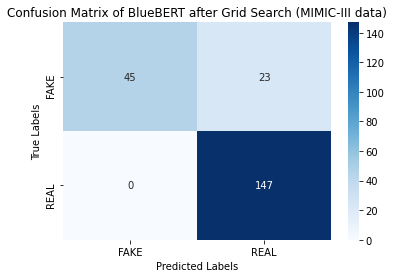

In [72]:
cm_bert = confusion_matrix(test_y, preds, labels=[1,0])
ax= plt.subplot()
sns.heatmap(cm_bert, annot=True, ax = ax, cmap='Blues', fmt="d")

ax.set_title('Confusion Matrix of BlueBERT after Grid Search (MIMIC-III data)')

ax.set_xlabel('Predicted Labels')
ax.set_ylabel('True Labels')

ax.xaxis.set_ticklabels(['FAKE', 'REAL'])
ax.yaxis.set_ticklabels(['FAKE', 'REAL'])
plt.savefig('Confusion_matrix_BlueBERT(grid search)_mimic')